In [1]:
from IPython.display import display, Markdown

scenario_info = """"""
scenario_folder = "scenario_02"

In [2]:

display(Markdown("""
# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"
"""))
display(Markdown(scenario_info))


# Scenario Analysis - "Grid modelling to assess electrofuels supply potential - The impact of electrofuels on the US electricity grid"


---

## 1. Setup and Data Loading

*This section handles the initial setup, including importing necessary libraries and loading the solved PyPSA-Earth networks.*

### 1.1. Import Libraries

In [3]:
!pip install plotly -qq

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pycountry

import pypsa
from pypsa.plot import add_legend_circles, add_legend_lines, add_legend_patches
from pathlib import Path

import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import box
from matplotlib.offsetbox import AnnotationBbox, AuxTransformBox
from matplotlib.patches import Wedge
from matplotlib.patches import Patch
import matplotlib.path as mpath
import matplotlib.transforms as mtransforms
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.font_manager import FontProperties
from IPython.display import display, HTML, Markdown
from matplotlib.font_manager import FontProperties
from functools import reduce
from collections import defaultdict
import plotly.express as px
import plotly.graph_objects as go
from shapely.geometry import LineString
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import yaml
from collections import OrderedDict
import warnings
warnings.filterwarnings("ignore")

from _helpers import *

/home/user/miniforge3/envs/pypsa-earth/lib/python3.10/site-packages/pypsa/networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



In [5]:
with open('plotting.yaml', 'r') as file:
    plotting = yaml.safe_load(file)

tech_colors = plotting['tech_colors']
nice_names = plotting['nice_names']
rename_techs_capex = plotting['rename_tech_capex']
rename_techs_opex = plotting['rename_tech_opex']
rename_tech_colors = plotting['renamed_tech_colors']
categories_capex = plotting['categories_capex']
categories_opex = plotting['categories_opex']
tech_power_color = plotting['tech_power_color']
nice_names_power = plotting['nice_names_power']
tech_power_order = plotting['tech_power_order']
emm_mapping = plotting['emm_mapping']

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None) 
pd.set_option('display.width', None)    
pd.set_option('display.max_colwidth', None)

import plotly.io as pio
pio.renderers.default = 'colab'

### 1.2. Load Solved Network(s)

The `scenario_dir` variable can be used to switch to a different scenario. The base year results are common for all the scenarios.

In [7]:
# -----------------------------
# Project folder path
# -----------------------------
project_root = Path().resolve()

# -----------------------------
# Base year network path
# -----------------------------
#base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-24H_24H_2020_0.071_AB_10export.nc"
base_year_file = project_root / "results" / "base_year" / "elec_s_100_ec_lcopt_Co2L-24H_24H_2020_0.071_AB_0export.nc"

networks = {
    "Base_2023": pypsa.Network(base_year_file)
}

# -----------------------------
# Scenario folder path (single scenario)
# -----------------------------
scenario_dir = project_root / "results" / "scenarios" / f"{scenario_folder}" #change the number to choose the scenario of your interest

## Folder structure
#  project_root/
#  └── notebooks/
#       ├── scenario_analysis.ipynb
#       └── results/
#            ├── base_year/
#            │   ├── elec_s_100_ec_lcopt_Co2L-3H_3H_2020_0.071_AB_10export.nc
#            └── scenarios/
#                 ├── scenario_01/
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2030_0.071_AB_10export.nc
#                 │   ├── elec_s_100_ec_lcopt_3H_3H_2035_0.071_AB_10export.nc
#                 │   └── elec_s_100_ec_lcopt_3H_3H_2040_0.071_AB_10export.nc
#                 ├── scenario_02/
#                 ├── ...
#                 ├── scenario_10/

years = [2030, 2035, 2040]

# -----------------------------
# Upload available networks per year
# -----------------------------
for year in years:
    #file_name = f"elec_s_100_ec_lv1_3H_3H_{year}_0.071_AB_10export.nc"
    file_name = f"elec_s_100_ec_lv1_CCL-24H_24H_{year}_0.071_AB_0export.nc"
    #file_name = f"elec_s_100_ec_lcopt_3H_3H_{year}_0.071_AB_10export.nc"
    # file_name = f"elec_s_100_ec_lv1_CCL-24H_24H_{year}_0.071_AB_0export.nc"
    file_path = scenario_dir / file_name

    if file_path.exists():
        scenario_name = scenario_dir.name  # e.g., "scenario_01"
        key = f"{scenario_name}_{year}"
        networks[key] = pypsa.Network(file_path)
        print(f"Loaded: {key}")
    else:
        print(f"Missing: {file_path.relative_to(project_root)}")

network_names = list(networks.keys())
print("\n Uploaded networks:")
print(list(networks.keys()))

INFO:pypsa.io:Imported network elec_s_100_ec_lcopt_Co2L-24H_24H_2020_0.071_AB_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network elec_s_100_ec_lv1_CCL-24H_24H_2030_0.071_AB_0export.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loaded: scenario_02_2030
Missing: results/scenarios/scenario_02/elec_s_100_ec_lv1_CCL-24H_24H_2035_0.071_AB_0export.nc
Missing: results/scenarios/scenario_02/elec_s_100_ec_lv1_CCL-24H_24H_2040_0.071_AB_0export.nc

 Uploaded networks:
['Base_2023', 'scenario_02_2030']


In [8]:
grid_region_shapes_path = project_root / "needs_grid_regions_aggregated.geojson"
state_shapes_path = project_root / "gadm41_USA_1.json"

regions_onshore = gpd.read_file(grid_region_shapes_path)
emm_shapes_path = "EIA_market_module_regions/EMM_regions.geojson"
regional_fees = pd.read_csv("EIA_market_module_regions/regional_fees.csv")

In [9]:
for network in networks.keys():
    attach_grid_region_to_buses(networks[network], grid_region_shapes_path)
    attach_state_to_buses(networks[network], state_shapes_path)
    attach_emm_region_to_buses(networks[network], emm_shapes_path, distance_crs="EPSG:3857")

---

## 2. Total system cost

In [10]:
all_system_costs = []

for name_tag, network in networks.items():
    df_yearly = compute_system_costs(
        network=network,
        rename_capex=rename_techs_capex,
        rename_opex=rename_techs_opex,
        name_tag=name_tag
    )
    all_system_costs.append(df_yearly)

df_system_costs_all = pd.concat(all_system_costs, ignore_index=True)

df_system_costs_all['macro_category'] = df_system_costs_all.apply(
    lambda row: assign_macro_category(row, categories_capex, categories_opex),
    axis=1
)

# Plot CAPEX
plot_stacked_costs_by_year_plotly(df_system_costs_all, "Capital expenditure", tech_colors=rename_tech_colors)

# Plot OPEX
plot_stacked_costs_by_year_plotly(df_system_costs_all, "Operational expenditure", tech_colors=rename_tech_colors)
plt.show()


In [11]:
try:
    del df_original_costs, power_techs, all_original_costs
except:
    pass

# Rebuild cost data with links-only approach
all_original_costs = []
for name_tag, network in networks.items():
    df_costs = compute_links_only_costs(network, name_tag)
    all_original_costs.append(df_costs)

df_original_costs = pd.concat(all_original_costs, ignore_index=True)

# Identify power generation technologies
power_techs = identify_power_generation_technologies(
    rename_techs_capex, rename_techs_opex, categories_capex, categories_opex
)

# Process data for visualization
# Filter for technologies of interest only
mask = df_original_costs["tech_label"].isin(nice_names_power.keys())
df_power = df_original_costs[mask].copy()
# Apply mapping
df_power["tech_label"] = df_power["tech_label"].replace(nice_names_power)

# Aggregate technologies with same name (e.g. Offshore Wind AC+DC)
df_power_aggregated = df_power.groupby(
    ['tech_label', 'cost_type', 'year', 'scenario'], 
    as_index=False
).agg({
    'cost_billion': 'sum'
})

# Get mapped technology names
power_techs_mapped = set(df_power_aggregated['tech_label'].unique())

# Create charts
fig1 = plot_power_generation_details(
    df_power_aggregated,
    "Capital expenditure",
    power_techs_mapped,
    tech_colors=tech_power_color,
    nice_names=None,
    tech_order=tech_power_order
)

fig2 = plot_power_generation_details(
    df_power_aggregated,
    "Operational expenditure", 
    power_techs_mapped,
    tech_colors=tech_power_color,
    nice_names=None,
    tech_order=tech_power_order
)

# Show charts
fig1.show()
fig2.show()

In [12]:
df_h2_efuels_results = create_h2_efuels_analysis(networks)

No data for Operational expenditure


## 3. Electricity demand

*This section illustrates results concerning electricity demand across the different sectors in the model, with a specific focus on data centers.*

### 3.1. Electricity demand by service
*This section reports results for electricity demand related to the different sectors, providing a comparison against the NREL Electrification Futures Studies (EFS) scenarios.*

In [13]:
# Industrial processes consuming AC electricity
target_processes = [
    "SMR CC", "Haber-Bosch", "ethanol from starch", "ethanol from starch CC",
    "DRI", "DRI CC", "DRI H2", "BF-BOF", "BF-BOF CC", "EAF",
    "dry clinker", "cement finishing", "dry clinker CC"
]

# Static and dynamic loads
static_load_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
dynamic_load_carriers = ["AC", "services electricity", "land transport EV", "data center"]

demand = pd.DataFrame(columns=networks.keys(),
                      index=dynamic_load_carriers + static_load_carriers + ["total demand"])
demand.index.name = "Load type (TWh)"

for name, n in networks.items():
    nhours = n.snapshot_weightings.objective.sum()

    # Static loads
    static_totals = (
        n.loads.groupby("carrier").sum().p_set
        .reindex(static_load_carriers)
        .fillna(0)
    )
    static_load_twh = static_totals.sum() * nhours / 1e6

    # Industrial AC
    process_links = n.links[n.links.carrier.isin(target_processes)]
    ac_input_links = process_links[process_links.bus0.map(n.buses.carrier) == "AC"].index
    ind_ac_profile = n.links_t.p0[ac_input_links].sum(axis=1)
    ind_ac_twh = (ind_ac_profile * n.snapshot_weightings.objective).sum() / 1e6

    # Non-industrial AC
    ac_loads = n.loads[n.loads.carrier == "AC"]
    industrial_ac_buses = n.links.loc[ac_input_links, "bus0"].unique()
    ac_non_ind_idx = ac_loads[~ac_loads.bus.isin(industrial_ac_buses)].index
    ac_profile = n.loads_t.p_set[ac_non_ind_idx.intersection(n.loads_t.p_set.columns)].sum(axis=1)
    ac_twh = (ac_profile * n.snapshot_weightings.objective).sum() / 1e6 - ind_ac_twh

    # Services and EVs
    serv_idx = [i for i in n.loads[n.loads.carrier == "services electricity"].index
                if i in n.loads_t.p_set.columns]
    ev_idx = [i for i in n.loads[n.loads.carrier == "land transport EV"].index
              if i in n.loads_t.p_set.columns]
    serv_profile = n.loads_t.p_set[serv_idx].sum(axis=1) if serv_idx else 0
    ev_profile = n.loads_t.p_set[ev_idx].sum(axis=1) if ev_idx else 0
    serv_twh = (serv_profile * n.snapshot_weightings.objective).sum() / 1e6
    ev_twh = (ev_profile * n.snapshot_weightings.objective).sum() / 1e6

    # Data centers
    data_center_p_set_sum = n.loads.loc[n.loads.carrier == "data center", "p_set"].sum()
    data_center_twh = data_center_p_set_sum * nhours / 1e6

    # Other electricity (included in industrial consumption)
    other_idx = [i for i in n.loads[n.loads.carrier == "other electricity"].index
                 if i in n.loads_t.p_set.columns]
    other_profile = n.loads_t.p_set[other_idx].sum(axis=1) if other_idx else 0
    other_twh = (other_profile * n.snapshot_weightings.objective).sum() / 1e6

    industry_static_twh = static_totals.get("industry electricity", 0) * nhours / 1e6
    industry_elec_twh = industry_static_twh + ind_ac_twh + other_twh

    demand.loc["rail transport electricity", name] = static_totals.get("rail transport electricity", 0) * nhours / 1e6
    demand.loc["agriculture electricity", name] = static_totals.get("agriculture electricity", 0) * nhours / 1e6
    demand.loc["industry electricity", name] = industry_elec_twh
    demand.loc["AC", name] = ac_twh
    demand.loc["services electricity", name] = serv_twh
    demand.loc["land transport EV", name] = ev_twh
    demand.loc["data center", name] = data_center_twh
    demand.loc["total demand", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + data_center_twh + other_twh
    )
    demand.loc["total demand no data center", name] = (
        static_load_twh + ac_twh + ind_ac_twh + serv_twh + ev_twh + other_twh
    )


In [14]:
# NREL reference values (2023, 2030, 2040)
nrel_data_medium = {
    "AC (residential + some industrial processes)": [1360.81, 1359.91, 1392.19],
    "services electricity": [1381.11, 1398.69, 1579.71],
    "land transport EV":    [13.10,	275.97,	714.41],
    "rail transport electricity": [7.29, 7.64, 8.29],
    "agriculture electricity": [np.nan, np.nan, np.nan],
    "industry electricity": [1036.81, 1109.69, 1213.94],
    "data center": [np.nan, np.nan, np.nan],
    "total demand (incl. data centers)": [3799.12, 4293.30, 5072.86],
    "total demand (excl. data centers)": [3799.12, 4293.30, 5072.86],
}

nrel_data_high = {
    "AC (residential + some industrial processes)": [1360.81, 1395.21, 1529.51],
    "services electricity": [1381.11, 1470.10, 1673.71],
    "land transport EV":    [13.10, 349.15, 1039.76],
    "rail transport electricity": [7.29, 9.96, 12.71],
    "agriculture electricity": [np.nan, np.nan, np.nan],
    "industry electricity": [1036.81, 1152.90, 1286.24],
    "data center": [np.nan, np.nan, np.nan],
    "total demand (incl. data centers)": [3799.12, 4377.32,	6713.68],
    "total demand (excl. data centers)": [3799.12, 4377.32,	6713.68],
}

# Mapping PyPSA names to NREL names
row_rename_map = {
    "AC": "AC (residential + some industrial processes)",
    "total demand": "total demand (incl. data centers)",
    "total demand no data center": "total demand (excl. data centers)"
}

# Extract years from network names
network_years = {}
for key in networks:
    match = re.search(r'(\d{4})', key)
    if match:
        network_years[int(match.group(1))] = key

# Determine the current scenario from network names (e.g., scenario_05)
scenario_keys = [k for k in networks if "scenario_" in k]
if scenario_keys:
    current_scenario = scenario_keys[0].split("_")[0] + "_" + scenario_keys[0].split("_")[1]
else:
    current_scenario = None

# Select appropriate NREL reference data based on scenario
if current_scenario in ["scenario_05", "scenario_06"]:
    nrel_data = nrel_data_high
else:
    nrel_data = nrel_data_medium

# Prepare the comparison table
rows = list(nrel_data.keys())
columns = pd.MultiIndex.from_product(
    [sorted(network_years.keys()), ["PyPSA-Earth", "NREL", "diff %"]]
)
comparison_df = pd.DataFrame(index=rows, columns=columns)

# Populate the comparison values
for year, net_key in network_years.items():
    for row in rows:
        pypsa_row = {v: k for k, v in row_rename_map.items()}.get(row, row)
        
        pypsa_val = demand.at[pypsa_row, net_key] if pypsa_row in demand.index else np.nan
        nrel_vals = nrel_data.get(row, None)

        if nrel_vals and year in [2023, 2030, 2040]:
            col_idx = [2023, 2030, 2040].index(year)
            nrel_val = nrel_vals[col_idx]
        else:
            nrel_val = np.nan

        comparison_df.at[row, (year, "PyPSA-Earth")] = pypsa_val
        comparison_df.at[row, (year, "NREL")] = nrel_val

        if pd.notna(pypsa_val) and pd.notna(nrel_val) and nrel_val != 0:
            diff = 100 * (pypsa_val - nrel_val) / nrel_val
        else:
            diff = np.nan
        comparison_df.at[row, (year, "diff %")] = diff

# Style function to highlight significant differences
def highlight_diff(val):
    if pd.isna(val):
        return ''
    if val > 10:
        return 'background-color: #ffcccc'  # light red
    elif val < -10:
        return 'background-color: #cce5ff'  # light blue
    else:
        return 'background-color: #d4edda'  # light green

# Apply styling to the diff columns
styled = comparison_df.style
for year in network_years:
    styled = styled.applymap(highlight_diff, subset=pd.IndexSlice[:, (year, "diff %")])
styled = styled.format(na_rep="N/A", precision=2)

# Display final table
print("\n Electric load by sector (TWh/year)")
display(styled)


 Electric load by sector (TWh/year)


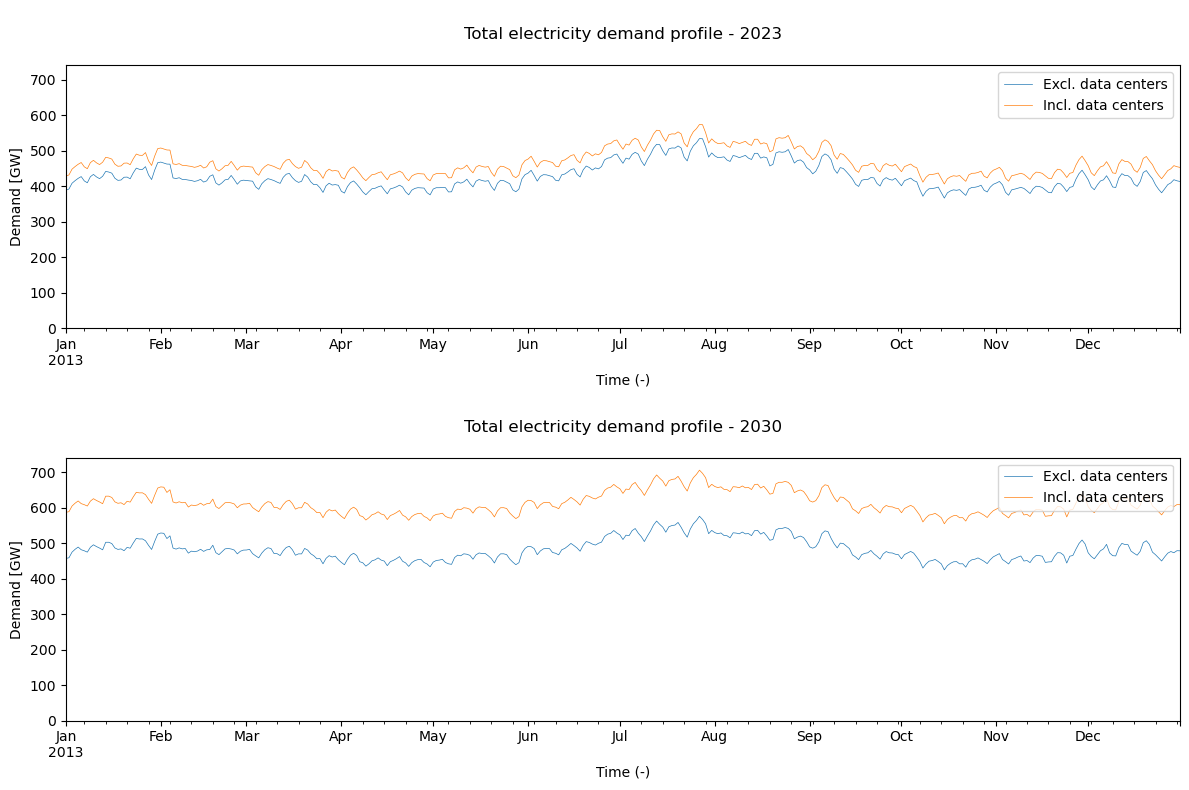

In [15]:
# Extract years from network names
years = {}
for name in networks:
    match = re.search(r"\d{4}", name)
    if match:
        years[int(match.group())] = name
years = dict(sorted(years.items()))  # sort by year

# Compute y-axis max (in GW) and build demand profiles
y_max = 0
demand_profiles_incl = {}
demand_profiles_excl = {}

for year, name in years.items():
    n = networks[name]
    nhours = n.snapshot_weightings.objective.sum()

    # Dynamic loads: AC, services, EV, other electricity
    dynamic_loads = n.loads[n.loads.carrier.isin(["AC", "services electricity", "land transport EV", "other electricity"])]
    dynamic_idx = dynamic_loads.index.intersection(n.loads_t.p_set.columns)
    dyn_profile = n.loads_t.p_set[dynamic_idx].sum(axis=1)

    # Static loads: rail, agriculture, industry
    static_carriers = ["rail transport electricity", "agriculture electricity", "industry electricity"]
    static_load = n.loads[n.loads.carrier.isin(static_carriers)]
    static_sum = static_load.groupby("carrier").sum()["p_set"].sum()  # MW
    static_profile = pd.Series(static_sum, index=n.snapshots)

    # Data centers (flat profile if present)
    if "data center" in n.loads.carrier.values:
        dc_sum = n.loads[n.loads.carrier == "data center"]["p_set"].sum()
        dc_profile = pd.Series(dc_sum, index=n.snapshots)
    else:
        dc_profile = 0

    # Total profiles (in GW)
    profile_excl = (dyn_profile + static_profile) / 1000
    profile_incl = (dyn_profile + static_profile + dc_profile) / 1000

    demand_profiles_excl[year] = profile_excl
    demand_profiles_incl[year] = profile_incl

    y_max = max(y_max, profile_incl.max())

y_max *= 1.05  # add 5% margin

# Plot profiles for each year
fig, axes = plt.subplots(nrows=len(years), figsize=(12, 4 * len(years)), sharey=True)

if len(years) == 1:
    axes = [axes]  # ensure list if only one subplot

for ax, (year, name) in zip(axes, years.items()):
    demand_profiles_excl[year].plot(ax=ax, linewidth=0.5, color="tab:blue", label="Excl. data centers")
    demand_profiles_incl[year].plot(ax=ax, linewidth=0.5, color="tab:orange", label="Incl. data centers")

    ax.set_title(f"\nTotal electricity demand profile - {year}\n")
    ax.set_xlabel("Time (-)")
    ax.set_ylabel("Demand [GW]")
    ax.set_ylim(0, y_max)
    ax.legend(loc="upper right")

plt.tight_layout()
plt.show()


### 3.2. Data center loads
*This section shows the subdivision of data center loads across the different States / Grid Regions.*

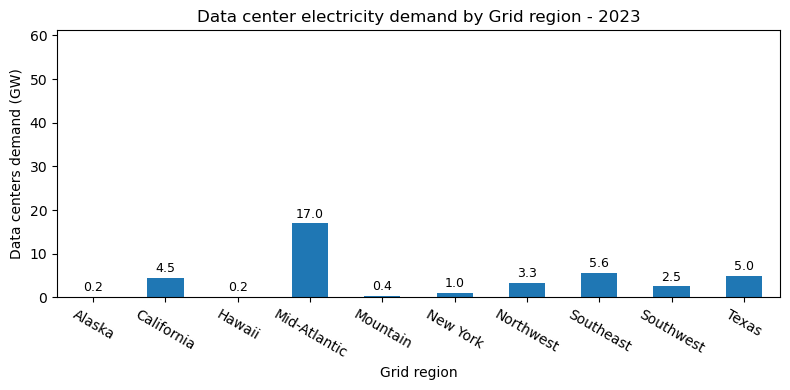

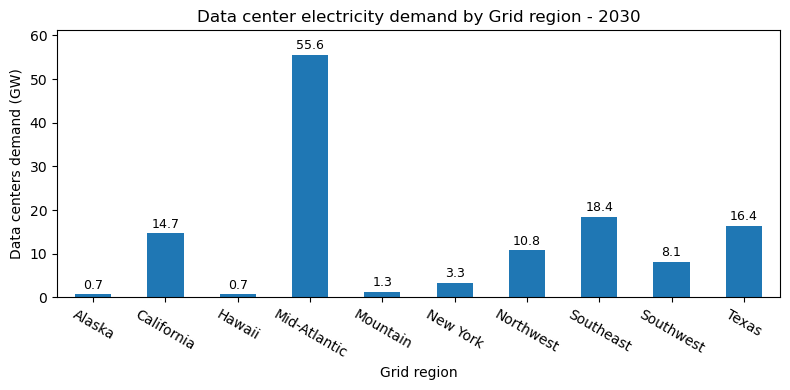

In [16]:
data_center_load = {}
for key, net in networks.items():
    year_match = re.search(r"\d{4}", key)
    short_key = year_match.group() if year_match else key 
    data_center_load[short_key] = compute_data_center_load(net)
    
# Compute the maximum value to normalize the y-axis
max_val = 0
for df in data_center_load.values():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    demand_by_grid_region = demand_by_grid_region[demand_by_grid_region > 0]
    if not demand_by_grid_region.empty:
        max_val = max(max_val, demand_by_grid_region.max())

ymax = max(max_val * 1.1, 1)

# Main loop to generate plots
for year, df in data_center_load.items():
    demand_by_grid_region = df.groupby("grid_region")["p_set"].sum().div(1e3)
    demand_by_grid_region = demand_by_grid_region[demand_by_grid_region > 0]

    if demand_by_grid_region.empty:
        print(f"\nSkipping {year}: No data centers demand\n")
        continue

    ax = demand_by_grid_region.plot(
        kind="bar",
        title=f"Data center electricity demand by Grid region - {year}",
        ylabel="Data centers demand (GW)",
        xlabel="Grid region",
        figsize=(8, 4),
        legend=False
    )

    # Add text labels on top of bars
    for i, value in enumerate(demand_by_grid_region.values):
        ax.text(
            i,
            value + ymax * 0.01,  # Slightly above the bar
            f"{value:.1f}",       # Format with 1 decimal place
            ha="center",
            va="bottom",
            fontsize=9,
            rotation=0
        )

    ax.set_ylim(0, ymax)
    plt.xticks(rotation=-30)
    plt.tight_layout()
    plt.show()

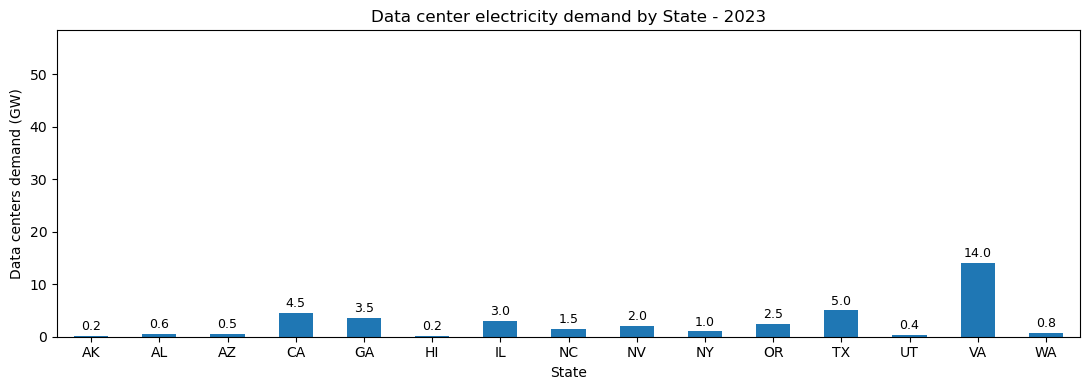

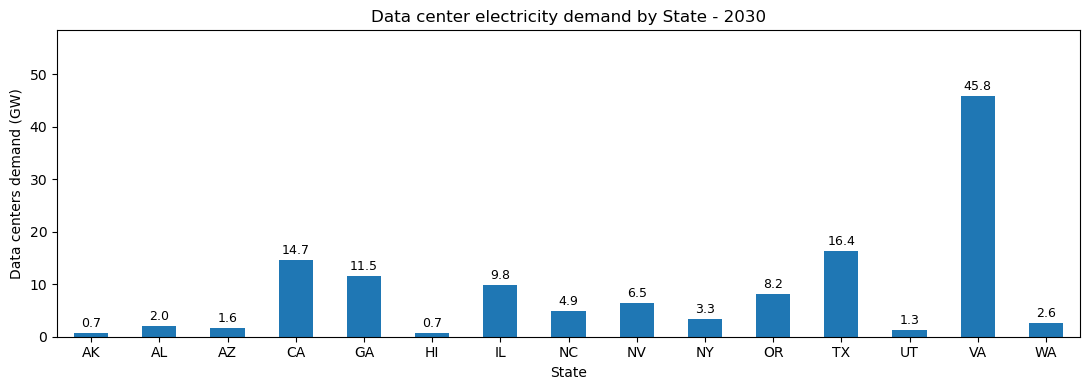

In [17]:
for key, df in data_center_load.items():    
    year_match = re.search(r"\d{4}", key)
    short_key = year_match.group() if year_match else key 
    demand_by_state = df.groupby("state")["p_set"].sum().div(1e3)
    demand_by_state = demand_by_state[demand_by_state > 0]

    if demand_by_state.empty:
        print(f"\nSkipping {key}: No data centers demand\n")
        continue

    # Extract year from key assuming format like "scenario_01_2030"
    year_match = re.search(r"\d{4}", key)
    year = year_match.group() if year_match else "Unknown Year"

    ax = demand_by_state.plot(
        kind="bar",
        title=f"Data center electricity demand by State - {year}",
        ylabel="Data centers demand (GW)",
        xlabel="State",
        figsize=(11, 4),
        legend=False
    )

    # Add text labels on top of bars
    for i, value in enumerate(demand_by_state.values):
        ax.text(
            i,
            value + max_val * 0.01,  # Slightly above the bar
            f"{value:.1f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

    ax.set_ylim(0, max_val * 1.05)
    plt.xticks(rotation=0) 
    plt.tight_layout()
    plt.show()

---

## 4. Installed capacity

*Here, we analyze the optimal installed capacities of generation, storage, and conversion technologies as determined by the model.*

### 4.1. Installed electricity capacity
*A map showing the total installed capacity (in GW) for each electricity generation carrier (e.g., Solar, Onshore Wind, Offshore Wind) at different locations.*

In [18]:
# regions_onshore = gpd.read_file(grid_region_shapes_path)

# # Prepare Data for Plotting
# gen_p_nom_opt = n.generators.groupby(["bus", "carrier"]).p_nom_opt.sum()
# sto_p_nom_opt = n.storage_units.groupby(["bus", "carrier"]).p_nom_opt.sum()
# bus_carrier_capacity = pd.concat([gen_p_nom_opt, sto_p_nom_opt])
# bus_carrier_capacity = bus_carrier_capacity[bus_carrier_capacity > 0]

# line_values = n.lines.s_nom
# links_values = n.links[n.links.carrier == "DC"].p_nom

# n = update_ac_dc_bus_coordinates(n)

# # Find carriers that need a color
# carriers_to_plot = bus_carrier_capacity.index.get_level_values(1).unique()
# for carrier in carriers_to_plot:
#     if carrier not in n.carriers.index:
#         n.add("Carrier", carrier)

# for idx in tech_colors.keys():
#     n.carriers.loc[idx, "color"] = tech_colors[idx]
    
# fill_missing_nice_names(n, nice_names)

# # Assign colors from the dictionary, using 'gray' for any not found
# n.carriers["color"] = n.carriers.index.map(tech_colors)
# n.carriers.color.fillna("gray", inplace=True)

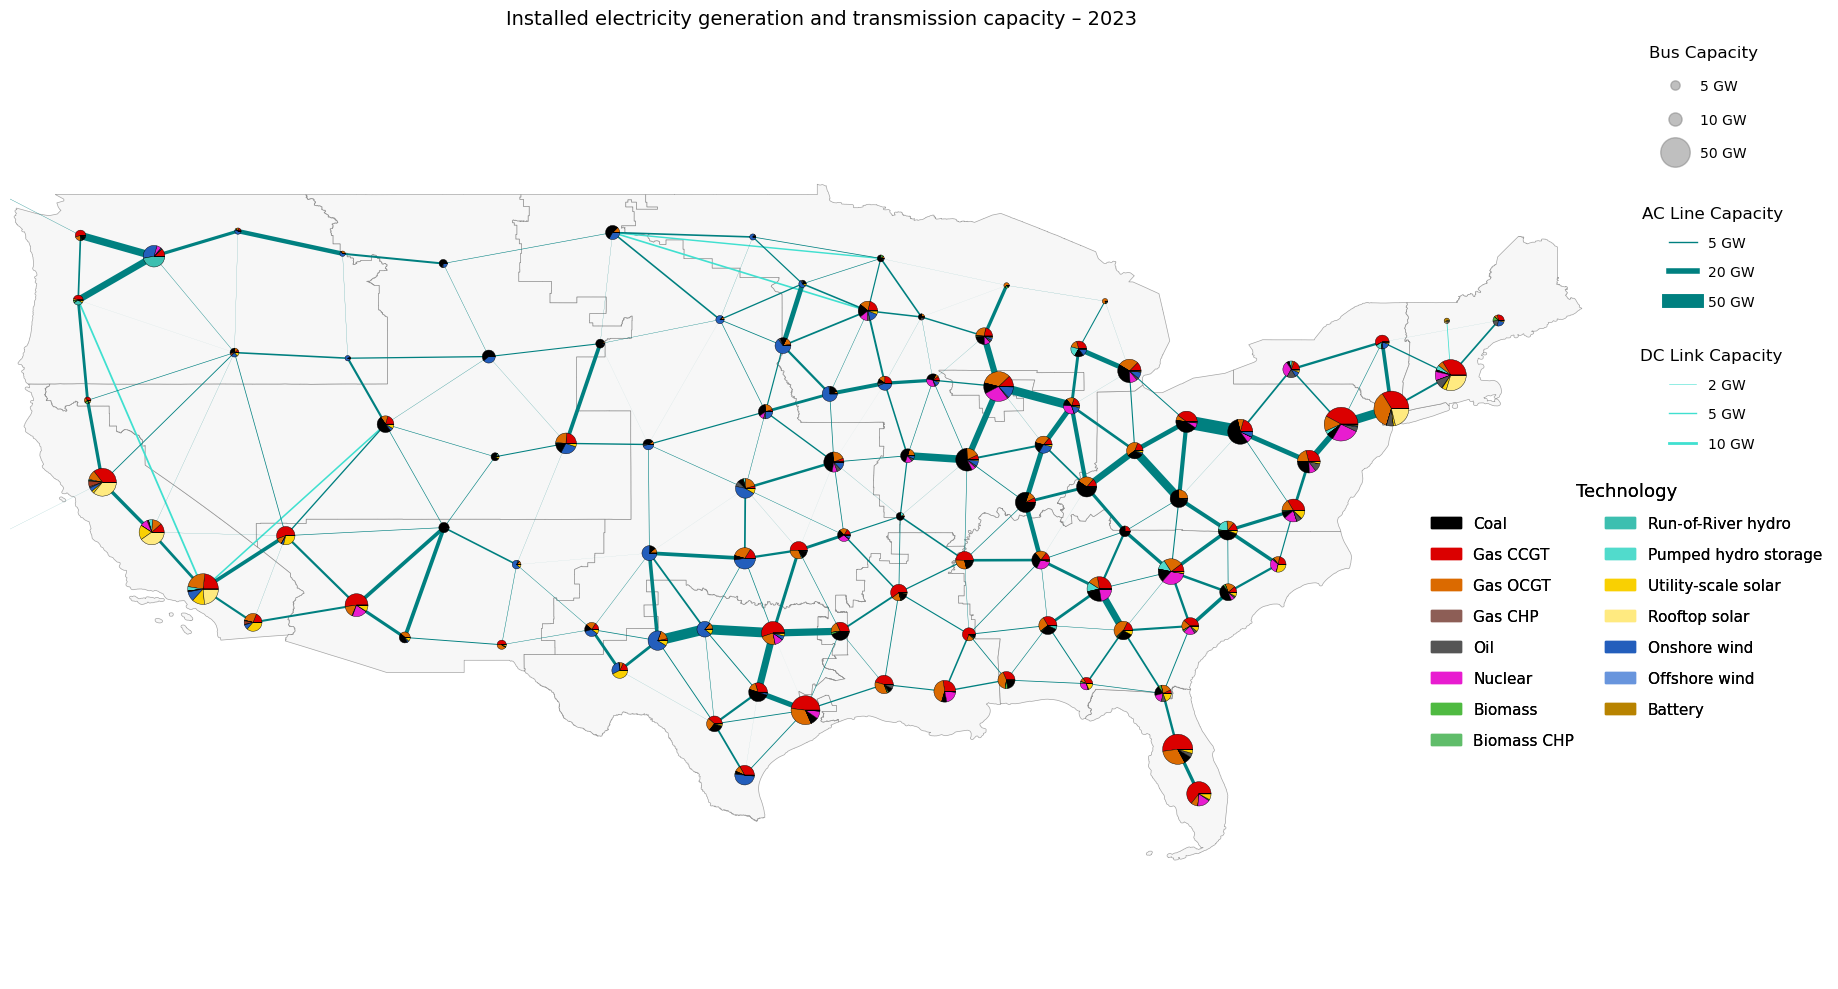

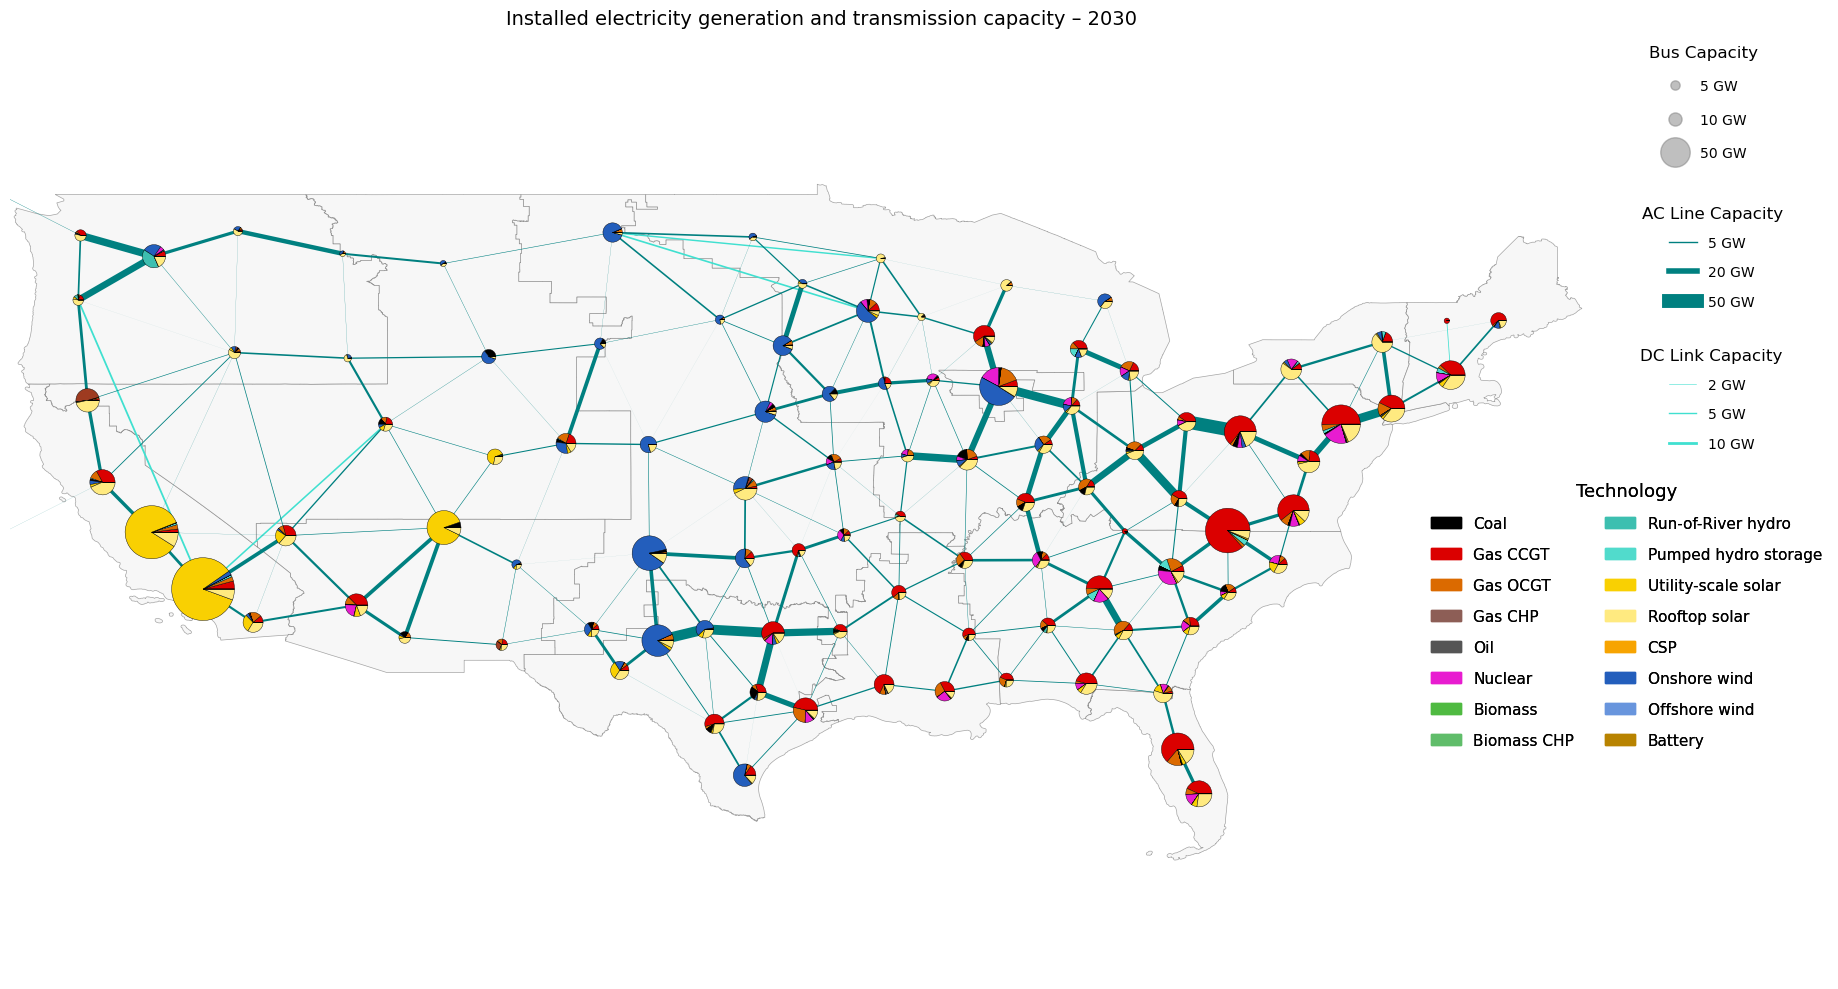

In [19]:
for key, n in networks.items():
    plot_network_generation_and_transmission(n, key, tech_colors, nice_names, regions_onshore)

In [20]:
df_capacity = compute_installed_capacity_by_carrier(networks, nice_names=nice_names)


Installed capacity by technology (GW)



2023    2030
carrier                             
Coal                  226.98   38.98
Gas CCGT              313.97  423.35
Gas OCGT              242.72  151.65
Gas CHP                 0.73    0.01
Oil                    32.52    2.93
Nuclear                99.96   96.18
Biomass                 9.01    1.43
Biomass CHP             0.00    0.00
Geothermal              3.89   15.00
Conventional hydro     69.54   58.08
Run-of-River hydro     10.44    9.60
Pumped hydro storage   22.01   21.98
Onshore wind          133.42  265.15
Utility-scale solar    60.39  312.83
Rooftop solar          50.44  358.30
CSP                     0.00    0.00
Battery                 0.00    0.00

In [21]:
# Invert nice_names so we can map pretty name to original PyPSA carrier
inverse_nice = {v: k for k, v in nice_names.items()}

def color_for_pretty(pretty_name: str) -> str:
    """Get the color for a pretty name, using tech_colors based on the original key"""
    orig = inverse_nice.get(pretty_name, pretty_name)
    return tech_colors.get(orig, "gray")

# Compute installed capacities (GW) per carrier
carrier_capacity_df = compute_installed_capacity_by_carrier(networks, display_result=False)

# Preferred order (matching the summary table)
preferred_order = [
    "Coal", "Gas CCGT", "Gas OCGT", "Gas CHP",
    "Oil", "Nuclear",
    "Biomass", "Biomass CHP", "Geothermal",        
    "Conventional hydro", "Run-of-River hydro", "Pumped hydro storage",
    "Onshore wind", "Offshore wind",
    "Utility-scale solar", "Rooftop solar", "CSP",
    "Battery"
]

# Convert pretty names → original carrier keys, keep only available ones
available = carrier_capacity_df.index.tolist()
preferred_index = [
    inverse_nice.get(p, p) for p in preferred_order if inverse_nice.get(p, p) in available
]
rest = [c for c in available if c not in preferred_index]
ordered_index = preferred_index + rest

# Reorder DataFrame rows
carrier_capacity_df = carrier_capacity_df.loc[ordered_index]

# Colors in the same order
color_list = [tech_colors.get(carrier, 'gray') for carrier in carrier_capacity_df.index]

# Create stacked bar chart with Plotly
fig = go.Figure()

for carrier, color in zip(carrier_capacity_df.index, color_list):
    pretty_name = nice_names.get(carrier, carrier)  # show nice names in legend/hover
    fig.add_trace(go.Bar(
        name=pretty_name,
        x=carrier_capacity_df.columns.astype(str),
        y=carrier_capacity_df.loc[carrier],
        marker_color=color,
        width=0.6,
        hovertemplate=f"%{{x}}<br>{pretty_name}: %{{y:.2f}} GW <extra></extra>"
    ))

# Layout settings
fig.update_layout(
    barmode='stack',
    legend_title="Technology",
    legend_traceorder="reversed",  # <-- reversed order for easier readability
    title=dict(
        text="Installed capacity - Electricity generation",
        x=0.5, xanchor='center',
        font=dict(size=16)
    ),
    xaxis_title="Year (-)",
    yaxis_title="Installed capacity (GW)",
    template="plotly_white",
    width=1200,
    height=800,
    xaxis=dict(
        tickangle=0,
        showline=True,
        linecolor='black'
    ),
    yaxis=dict(
        showline=True,
        linecolor='black'
    ),
    font=dict(size=12),
)

# Optional border around the plot
fig.add_shape(
    type="rect",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1, y1=1,
    line=dict(color="black", width=1),
    layer="below"
)

fig.show()


### 4.2. Transmission Line Expansion

In [22]:
for network_name, n in networks.items():
    year_match = re.search(r'\d{4}', network_name)
    year = year_match.group() if year_match else network_name
    
    df = compute_line_expansion_capacity(n)[0]  # grouped by grid_region
    
    df.index.name = 'Grid Region'
    
    df = df.rename(columns={
        "s_nom": "Transmission capacity (GW) - 2023",
        "s_nom_opt": f"Expanded transmission capacity (GW) - {year}"
    })
   
    df_display = df.style.format("{:.2f}")
    
    display(df_display)

In [23]:
for network_name, n in networks.items():
    year_match = re.search(r'\d{4}', network_name)
    year = year_match.group() if year_match else network_name
    
    df = compute_line_expansion_capacity(n)[1]  # grouped by state
    
    df.index.name = 'State'
    
    df = df.rename(columns={
        "s_nom": "Transmission capacity (GW) - 2023",
        "s_nom_opt": f"Expanded transmission capacity (GW) - {year}"
    })
    
    df_display = df.style.format("{:.2f}")
    
    display(df_display)

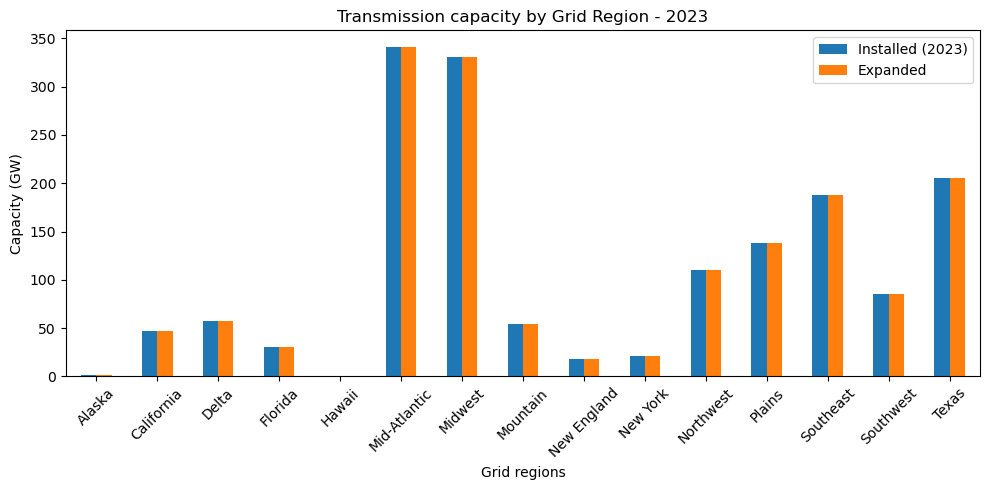

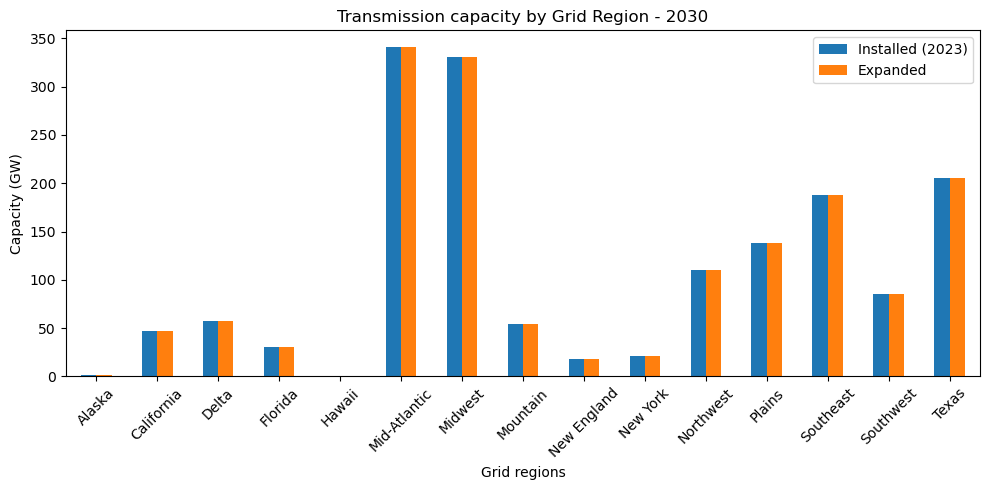

In [24]:
for network_name, n in networks.items():
    line_expan_cap = compute_line_expansion_capacity(n)[0]

    line_expan_cap = line_expan_cap.rename(columns={
        "s_nom": "Installed (2023)",
        "s_nom_opt": "Expanded"
    })
    
    year = network_name.split('_')[-1]
    line_expan_cap.plot(
        kind="bar",
        title=f"Transmission capacity by Grid Region - {year}",
        ylabel="Capacity (GW)",
        xlabel="Grid regions",
        figsize=(10, 5),
        legend=True
    )

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

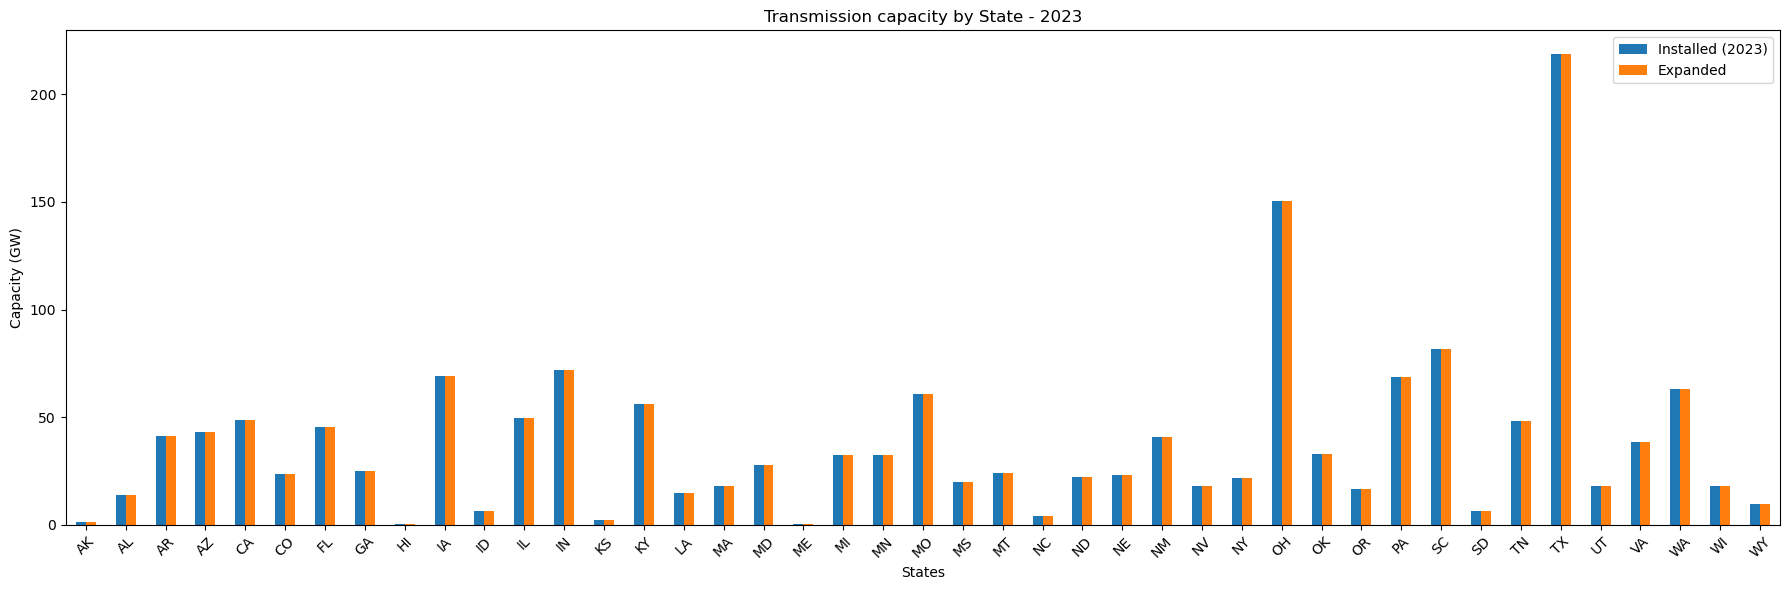

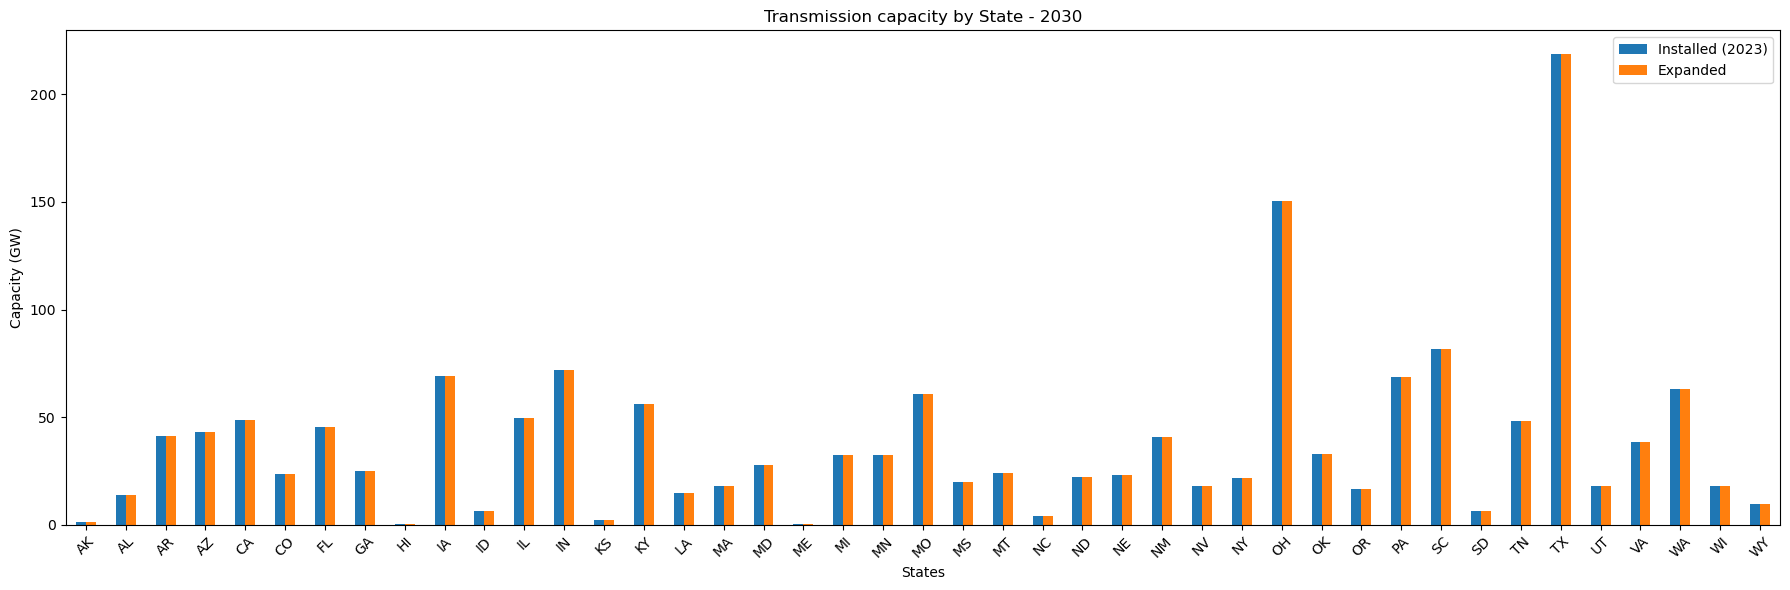

In [25]:
for network_name, n in networks.items():
    line_expan_cap = compute_line_expansion_capacity(n)[1]

    line_expan_cap = line_expan_cap.rename(columns={
        "s_nom": "Installed (2023)",
        "s_nom_opt": "Expanded"
    })
    
    year = network_name.split('_')[-1]
    line_expan_cap.plot(
        kind="bar",
        title=f"Transmission capacity by State - {year}",
        ylabel="Capacity (GW)",
        xlabel="States",
        figsize=(18, 6),
        legend=True
    )

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 4.3. Hydrogen production capacity
*This section reports results about installed hydrogen production capacity of the different electrolyzer technologies (e.g., Alkaline, PEM, SOEC).*

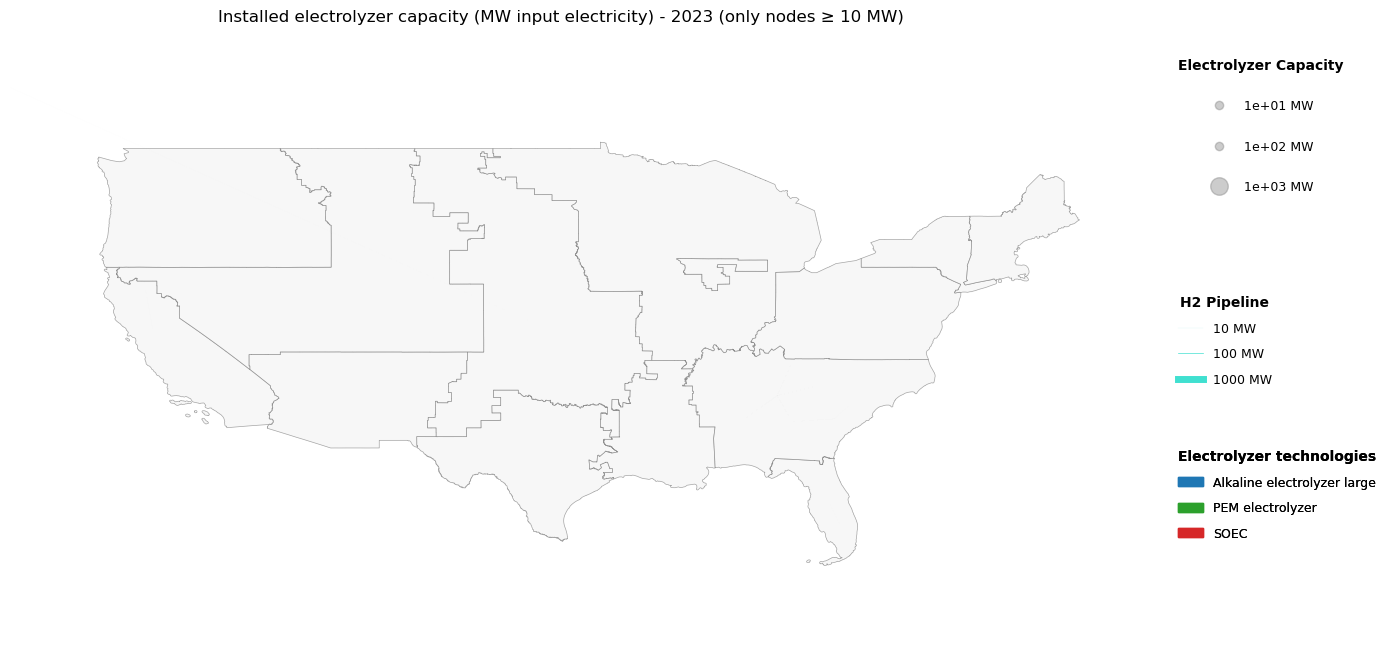

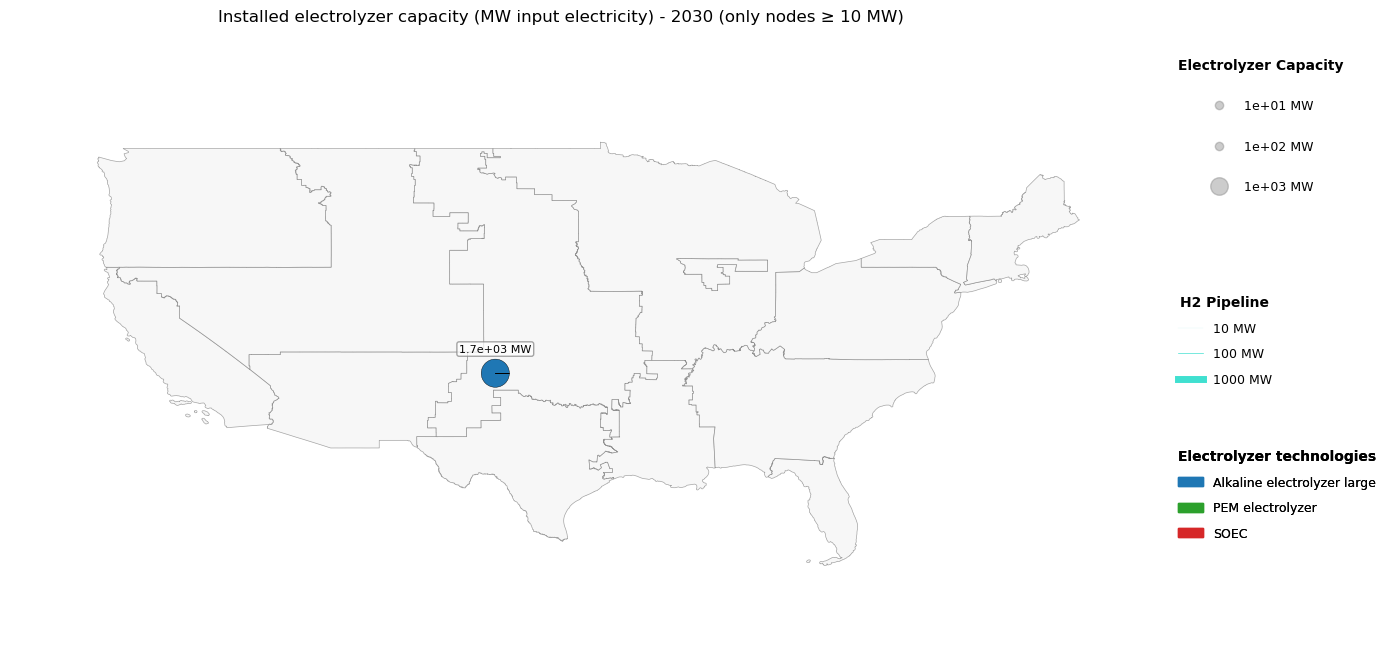

In [26]:
for key, net in networks.items():
    year = key[-4:]
    plot_h2_capacities_map(net, year, tech_colors, nice_names, regions_onshore)


Skipping 2023: no States with capacity > 1 MW



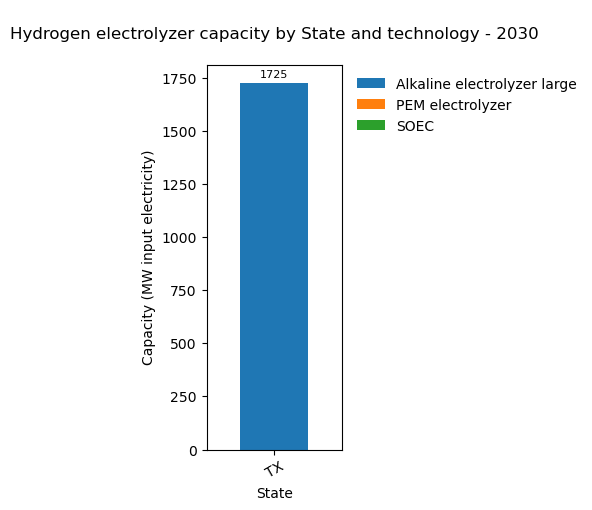

In [27]:
h2_cap_by_network = {}
max_n_states = 0
max_capacity = 0

for name, network in networks.items():
    h2_cap = compute_h2_capacities(network).groupby('state')[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    filtered = h2_cap[h2_cap.sum(axis=1) > 1]

    h2_cap_by_network[name] = filtered

    if not filtered.empty:
        max_n_states = max(max_n_states, filtered.shape[0])
        max_capacity = max(max_capacity, filtered.sum(axis=1).max())

for name, filtered in h2_cap_by_network.items():
    year = name[-4:]

    if filtered.empty:
        print(f"\nSkipping {year}: no States with capacity > 1 MW\n")
        continue

    plot_h2_capacities_by_state(filtered, year, max_capacity, max_n_states)



Skipping 2023: no Grid Regions with capacity > 1 MW



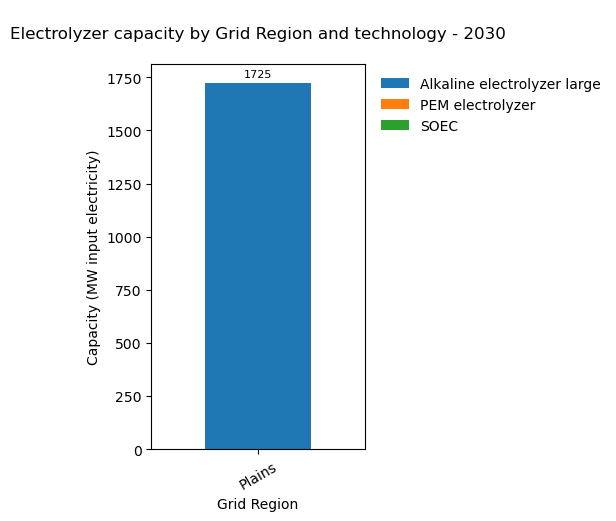

In [28]:
h2_cap_by_network = {}
max_n_grid_regions = 0
max_capacity = 0

for name, network in networks.items():
    h2_cap = compute_h2_capacities(network).groupby('grid_region')[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    filtered = h2_cap[h2_cap.sum(axis=1) > 1]

    h2_cap_by_network[name] = filtered

    if not filtered.empty:
        max_n_grid_regions = max(max_n_grid_regions, filtered.shape[0])
        max_capacity = max(max_capacity, filtered.sum(axis=1).max())

for name, filtered in h2_cap_by_network.items():
    year = name[-4:]

    if filtered.empty:
        print(f"\nSkipping {year}: no Grid Regions with capacity > 1 MW\n")
        continue

    plot_h2_capacities_by_grid_region(filtered, year, max_capacity, max_n_grid_regions)


In [29]:
for idx, network in enumerate(networks.keys()):
    year = network[-4:]
    
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['state'])[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    print(f"\nInstalled electrolyzer capacity by State (MW input electricity) - {year} (only States with capacity ≥ 1 MW)\n")

    df = h2_state_cap.T
    df = df.loc[:, (df >= 1).any(axis=0)]

    df.columns.name = "State"
    df.index.name = None

    display(df.style.format("{:.1e}"))


Installed electrolyzer capacity by State (MW input electricity) - 2023 (only States with capacity ≥ 1 MW)




Installed electrolyzer capacity by State (MW input electricity) - 2030 (only States with capacity ≥ 1 MW)



In [30]:
for idx, network in enumerate(networks.keys()):
    year = network[-4:]
    h2_state_cap = compute_h2_capacities(networks[network]).groupby(['grid_region'])[
        ['Alkaline electrolyzer large', 'PEM electrolyzer', 'SOEC']
    ].sum()

    print(f"\nInstalled electrolyzer capacity (MW input electricity) by Grid Region - {year} (only Grid Regions with capacity ≥ 1 MW))\n")

    df = h2_state_cap.sort_values(by=list(h2_state_cap.columns), ascending=False).T
    df.columns.name = "Grid Region"
    df.index.name = None
    df = df.loc[:, (df >= 1).any(axis=0)]

    display(df.style.format("{:.1e}"))


Installed electrolyzer capacity (MW input electricity) by Grid Region - 2023 (only Grid Regions with capacity ≥ 1 MW))




Installed electrolyzer capacity (MW input electricity) by Grid Region - 2030 (only Grid Regions with capacity ≥ 1 MW))



### 4.4. e-kerosene production capacity
*This sector reports information about installed capacity for Fischer-Tropsch synthesis plants for e-kerosene production.*

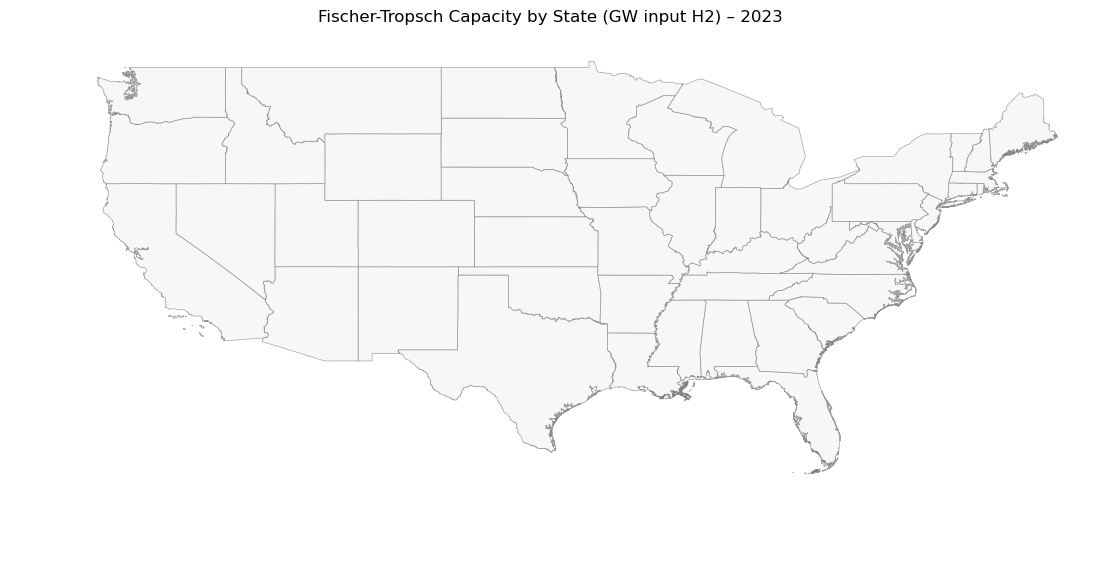

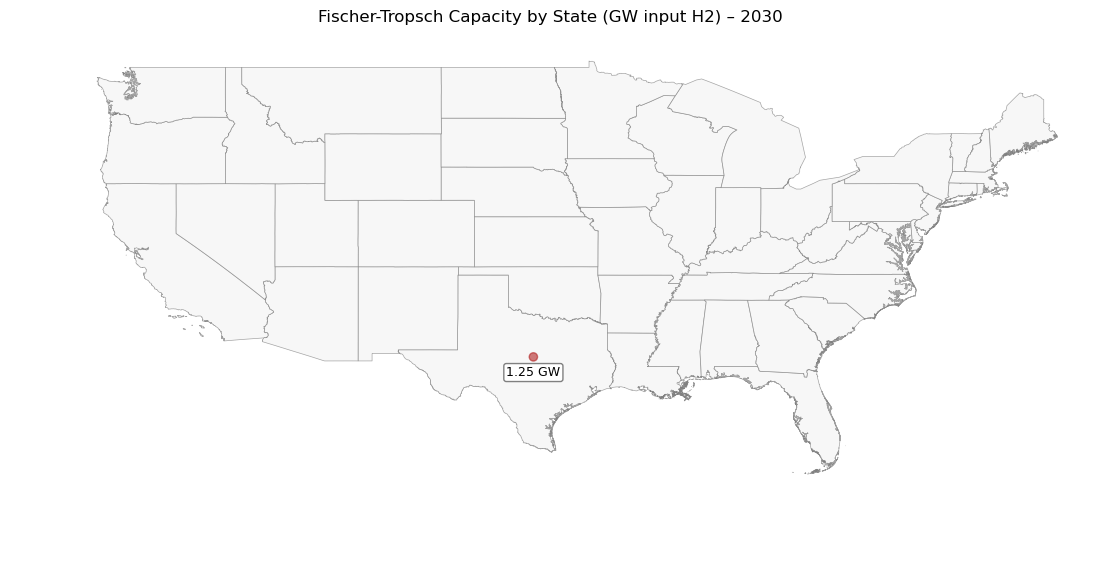

In [31]:
ft_state_table = {}

for name, net in networks.items():
    fig, ax, data = create_ft_capacity_by_state_map(
        net.copy(),
        path_shapes=state_shapes_path,
        network_name=name,
        min_capacity_gw=0.4
    )
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

    
    # data['grid_region'] = data.bus0.map(n.buses.grid_region)
    ft_state_capacity = data.groupby('state')['p_nom_gw'].sum()
    ft_state_table[name] = ft_state_capacity

In [32]:
# Representative plant capacity in MW (can be changed easily)
plant_capacity_mw = 400  

df = pd.DataFrame(ft_state_table)
df = df.reset_index()
df.rename(columns={df.columns[0]: 'State'}, inplace=True)
df = df.set_index('State')

# Extract only the year from network names
df.columns = [
    re.search(r'\d{4}', c).group() if re.search(r'\d{4}', c) else c
    for c in df.columns
]

df = df.fillna(0)

# Work with numeric values for filtering and plant calculation
df_num = df.astype(float)

# Apply filter year by year: set values < 0.4 GW to 0
df_num = df_num.where(df_num >= 0.4, 0)

# Compute plants (floor division by representative plant capacity)
df_plants = np.floor(df_num * 1000 / plant_capacity_mw).astype(int)

# Build combined DataFrame with labels like "Capacity (...) - 2025" and "N. of plants - 2025"
df_combined = pd.DataFrame(index=df_num.index)
for year in df_num.columns:
    df_combined[f"Capacity (GW input H2) - {year}"] = df_num[year].apply(lambda x: f"{x:.3e}")
    df_combined[f"N. of plants - {year}"] = df_plants[year]

# Style: highlight cells where plants >= 1 (both capacity and plants)
def highlight_df(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    for col in df.columns:
        if "N. of plants" in col:
            styles[col] = df[col].apply(
                lambda v: "background-color: #fff2b2;" if isinstance(v, (int, float)) and v >= 1 else ""
            )
        if "Capacity" in col:
            year = col.split(" - ")[1]
            plant_col = f"N. of plants - {year}"
            styles[col] = df[plant_col].apply(
                lambda v: "background-color: #fff2b2;" if v >= 1 else ""
            )
    return styles

styled_df = df_combined.style.apply(highlight_df, axis=None)

display(Markdown(
    f"\nInstalled FT capacity by State (GW input H2) "
    f"and equivalent number of representative plants ({plant_capacity_mw} MW each)\n"
))
display(styled_df)



Installed FT capacity by State (GW input H2) and equivalent number of representative plants (400 MW each)


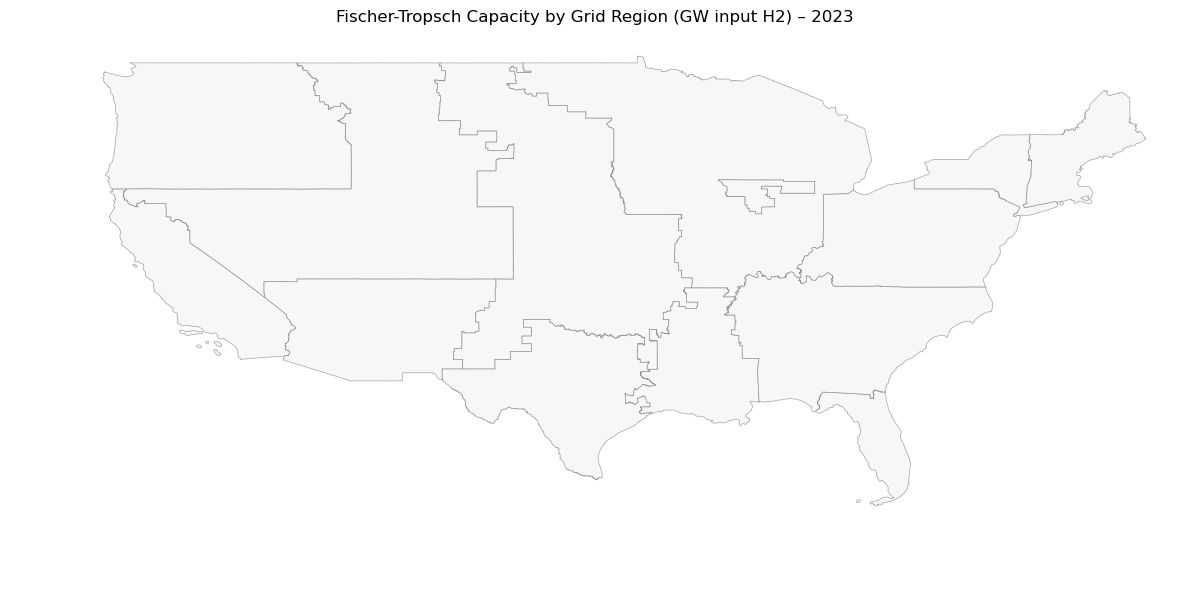

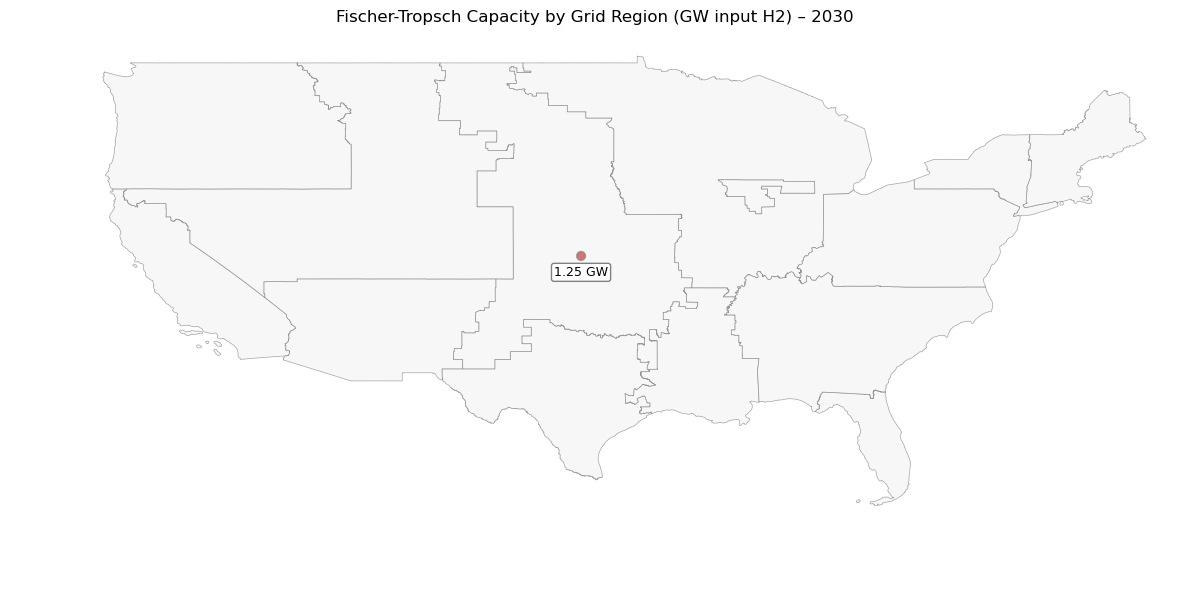

In [33]:
ft_grid_table = {}

for name, net in networks.items():
    fig, ax, data = create_ft_capacity_by_grid_region_map(
        net.copy(),
        path_shapes=grid_region_shapes_path,
        network_name=name,
        min_capacity_gw=0.4
    )
    ax.set_aspect('equal', adjustable='datalim')
    plt.show()

    ft_grid_table[name] = data.set_index('grid_region')['total_gw']

In [34]:
# Representative plant capacity in MW (can be changed easily)
plant_capacity_mw = 400  

df = pd.DataFrame(ft_grid_table)
df = df.reset_index()
df.rename(columns={df.columns[0]: 'Grid Region'}, inplace=True)
df = df.set_index('Grid Region')

# Extract only the year from network names
df.columns = [
    re.search(r'\d{4}', c).group() if re.search(r'\d{4}', c) else c
    for c in df.columns
]

df = df.fillna(0)

# Work with numeric values for filtering and plant calculation
df_num = df.astype(float)

# Apply filter year by year: set values < 0.4 GW to 0
df_num = df_num.where(df_num >= 0.4, 0)

# Compute plants (floor division by representative plant capacity)
df_plants = np.floor(df_num * 1000 / plant_capacity_mw).astype(int)

# Build combined DataFrame with labels like "Capacity (...) - 2025" and "N. of plants - 2025"
df_combined = pd.DataFrame(index=df_num.index)
for year in df_num.columns:
    df_combined[f"Capacity (GW input H2) - {year}"] = df_num[year].apply(lambda x: f"{x:.3e}")
    df_combined[f"N. of plants - {year}"] = df_plants[year]

# Style: highlight cells where plants >= 1 (both capacity and plants)
def highlight_df(df):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    for col in df.columns:
        if "N. of plants" in col:
            styles[col] = df[col].apply(
                lambda v: "background-color: #fff2b2;" if isinstance(v, (int, float)) and v >= 1 else ""
            )
        if "Capacity" in col:
            year = col.split(" - ")[1]
            plant_col = f"N. of plants - {year}"
            styles[col] = df[plant_col].apply(
                lambda v: "background-color: #fff2b2;" if v >= 1 else ""
            )
    return styles

styled_df = df_combined.style.apply(highlight_df, axis=None)

display(Markdown(
    f"\nInstalled FT capacity by Grid Region (GW input H2) "
    f"and equivalent number of representative plants ({plant_capacity_mw} MW each)\n"
))
display(styled_df)



Installed FT capacity by Grid Region (GW input H2) and equivalent number of representative plants (400 MW each)


---

##  5. Operational analysis

*This section explores electricity and hydrogen generation and dispatch.*

### 5.1. Electricity dispatch
*Electricity dispatch is assessed for each single source across the model years.*

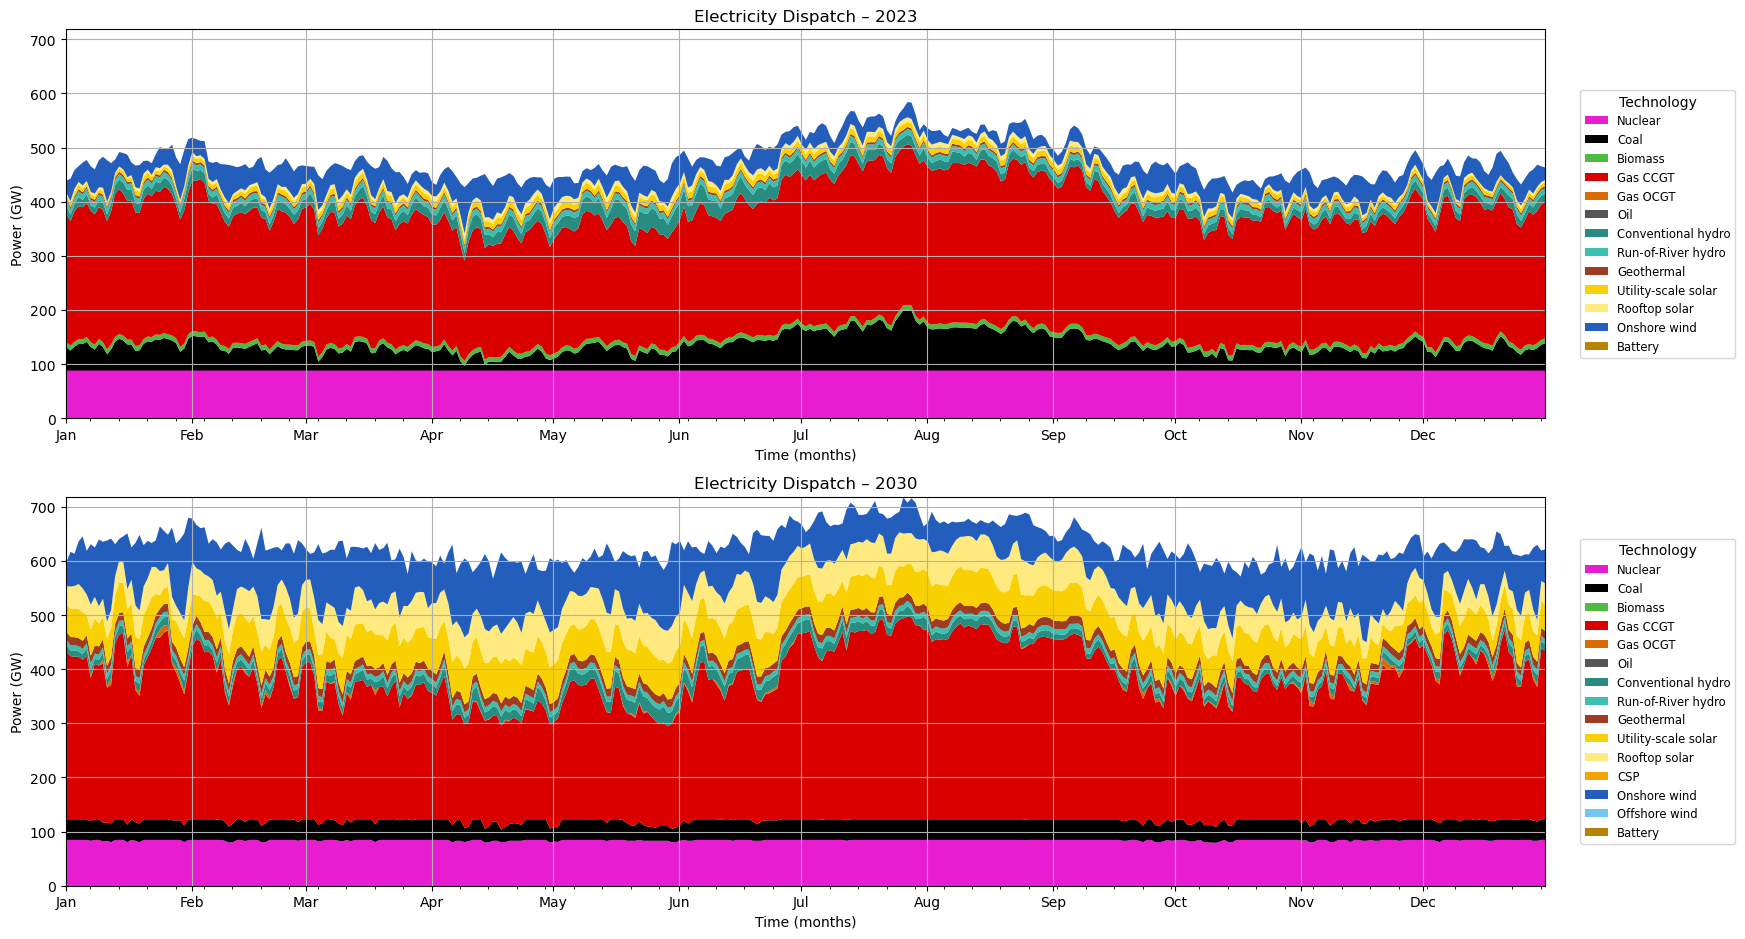

In [35]:
summary_list = []
max_y = 0

for key, n in networks.items():
    total_gwh, supply_gw = calculate_dispatch(n)
    summary_list.append({"Network": key, "Total Dispatch (GWh)": total_gwh})
    max_y = max(max_y, supply_gw.sum(axis=1).max())

ymax = max_y

fig, axes = plt.subplots(len(networks), 1, figsize=(22, 5 * len(networks)))

if len(networks) == 1:
    axes = [axes]

for ax, (key, n) in zip(axes, networks.items()):
    _, supply_gw = calculate_dispatch(n)

    supply_gw.index = pd.to_datetime(supply_gw.index)
    supply_gw = supply_gw.resample('24H').mean()
    
    ordered_columns = [
        'nuclear',
        'coal',
        'biomass',
        'CCGT',
        'OCGT',
        'oil',
        'hydro',
        'ror',
        'geothermal',
        'solar',
        'solar rooftop',
        'csp',
        'onwind',
        'offwind-ac',
        'offwind-dc',
        'battery discharger'
    ]

    supply_gw = supply_gw[[c for c in ordered_columns if c in supply_gw.columns]]

    supply_gw.plot.area(
        ax=ax,
        stacked=True,
        linewidth=0,
        color=[tech_colors.get(c, 'gray') for c in supply_gw.columns],
        legend=False
    )
    
    year = key[-4:]  # Extract the year
    ax.set_title(f"Electricity Dispatch – {year}")
    ax.set_ylabel("Power (GW)")
    ax.set_ylim(0, ymax)
    ax.grid(True)
    
    start = supply_gw.index.min().replace(day=1)
    end = supply_gw.index.max()
    month_starts = pd.date_range(start=start, end=end, freq='MS')
    
    ax.set_xlim(start, end)
    ax.set_xticks(month_starts)
    ax.set_xticklabels(month_starts.strftime('%b'))
    ax.tick_params(axis='x', which='both', labelbottom=True)
    ax.set_xlabel("Time (months)")

    handles, labels = ax.get_legend_handles_labels()
    
    sums = supply_gw.sum()
    
    filtered = [(h, l) for h, l in zip(handles, labels) if sums.get(l, 0) > 0]
    
    if filtered:
        handles, labels = zip(*filtered)
        pretty_labels = [nice_names.get(label, label) for label in labels]

        ax.legend(
            handles, pretty_labels,
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            title='Technology',
            fontsize='small',
            title_fontsize='medium'
        )


axes[-1].set_xlabel("Time (months)")
plt.tight_layout(rect=[0, 0.05, 0.80, 1])
plt.show()

### 5.2. Electricity generation
*Total electricity generation by source is reported by year, with an indication of the percentage covered by renewable or clean (renewables + nuclear) energy sources per State and at country-wise level.*

In [36]:
generation_summary = {}

for key, network in networks.items():
    year = key[-4:]  # Extract the year
    generation_summary[year] = calculate_total_generation_by_carrier(network)

generation_df = pd.DataFrame.from_dict(generation_summary, orient='index').fillna(0)
generation_df = generation_df.sort_index().round(2)

generation_df.columns = [nice_names.get(c, c) for c in generation_df.columns]

preferred_order = [
    "Coal", "Oil", "Gas OCGT", "Gas CCGT", "Gas CHP", "Nuclear", "Biomass", "Biomass CHP", "Conventional hydro", "Run-of-River hydro", "Geothermal", "Utility-scale solar", "Rooftop solar", "Onshore wind", "Offshore wind", "CSP", "Battery"]

available_cols = generation_df.columns.tolist()
ordered_cols = [c for c in preferred_order if c in available_cols] + \
               [c for c in available_cols if c not in preferred_order]

generation_df = generation_df[ordered_cols]
generation_df["Total"] = generation_df.sum(axis=1).round(2)

print("\nTotal electricity generation (TWh/year) by technology\n")
display(generation_df)



Total electricity generation (TWh/year) by technology



Coal  Oil  Gas OCGT  Gas CCGT  Gas CHP  Nuclear  Biomass  Biomass CHP  \
2023  431.53  0.1      0.00   2159.41     4.70   779.33    78.96          0.0   
2030  319.23  0.0     13.47   2381.43     0.06   743.52     0.00          0.0   

      Conventional hydro  Run-of-River hydro  Geothermal  Utility-scale solar  \
2023              154.02               91.49       34.07                80.77   
2030              129.83               84.09      131.40               508.33   

      Rooftop solar  Onshore wind  Offshore wind  CSP  Battery    Total  
2023          60.42        317.57            0.0  0.0      0.0  4192.37  
2030         469.45        742.01            0.0  0.0      0.0  5522.82

#### 5.2.1. CO2 emissions from electricity generation

In [37]:
# CO2 intensity [tCO2 per MWh_fuel] for original link carriers
co2_intensity = {
    "coal": 0.3361,
    "oil": 0.2571,
    "OCGT": 0.198,
    "CCGT": 0.198,
    "urban central gas CHP": 0.198
}

# carriers handled via Links (same list you used for generation)
link_carriers = [
    "coal", "oil", "OCGT", "CCGT", "biomass", "lignite",
    "urban central solid biomass CHP", "urban central gas CHP"
]

emissions_all_years = []

for net_key, net in networks.items():
    try:
        year = int(net_key[-4:])
    except ValueError:
        continue

    # --- snapshots and timestep (same logic as your generation function) ---
    snapshots_slice = slice(None)
    snapshots = net.snapshots[snapshots_slice]
    if len(snapshots) < 2:
        raise ValueError(f"Network {net_key} has insufficient snapshots")
    timestep_h = (snapshots[1] - snapshots[0]).total_seconds() / 3600

    # --- identify electric buses (same filter you used) ---
    electric_buses = set(
        net.buses.index[
            ~net.buses.carrier.str.contains("heat|gas|H2|oil|coal", case=False, na=False)
        ]
    )

    # accumulator (tCO2)
    emissions_per_carrier = {c: 0.0 for c in co2_intensity.keys()}

    # --- links: take electrical output on bus1 (p1), same as your generation ---
    for carrier in link_carriers:
        if carrier not in co2_intensity:
            continue  # we only emit for the carriers in co2_intensity

        links = net.links[
            (net.links.carrier == carrier) &
            (net.links.bus1.isin(electric_buses))
        ]
        if links.empty:
            continue

        # electrical power on bus1; keep only positive electrical output
        p1 = net.links_t.p1.loc[snapshots_slice, links.index]
        p1_positive = -p1.clip(upper=0)  # same trick: make export positive

        # ELECTRICAL energy [MWh]
        e_el_mwh = p1_positive.sum().sum() * timestep_h

        # average efficiency to back-calculate fuel input
        # (if per-link efficiencies differ a lot, weight them by energy)
        eta_series = links["efficiency"].replace({None: 1.0})
        # simple energy-weighted mean efficiency (robust): 
        # compute fuel per-link, then sum
        # fuel_input = sum( e_el_link / eta_link )
        # To do that, compute per-link electrical energy first:
        e_el_per_link = p1_positive.sum(axis=0) * timestep_h  # MWh per link

        # avoid division by zero / NaN
        valid = eta_series.notna() & (eta_series > 0)
        e_el_per_link = e_el_per_link[valid]
        eta_series = eta_series[valid]

        fuel_input_mwh = (e_el_per_link / eta_series).sum()

        # emissions [tCO2]
        emissions_tco2 = fuel_input_mwh * co2_intensity[carrier]
        emissions_per_carrier[carrier] += emissions_tco2

    # --- aggregate into Oil / Gas / Coal buckets (GtCO2) ---
    oil_val = emissions_per_carrier.get("oil", 0.0)
    coal_val = emissions_per_carrier.get("coal", 0.0)
    gas_val = (
        emissions_per_carrier.get("OCGT", 0.0) +
        emissions_per_carrier.get("CCGT", 0.0) +
        emissions_per_carrier.get("urban central gas CHP", 0.0)
    )

    emissions_all_years.append({
        "Year": year,
        "Oil": oil_val / 1e9,
        "Gas": gas_val / 1e9,
        "Coal": coal_val / 1e9,
        "Total": (oil_val + gas_val + coal_val) / 1e9
    })

# --- final table ---
emissions_df_gt = pd.DataFrame(emissions_all_years).set_index("Year").sort_index()

# colonna statistica (come prima)
emissions_df_gt["Total (Statistics)"] = emissions_df_gt.index.map(
    lambda y: 1.421 if y == 2023 else "-"
)

# reduction vs 2023
if 2023 in emissions_df_gt.index:
    base_2023 = emissions_df_gt.loc[2023, "Total"]
    emissions_df_gt["Reduction vs 2023 (%)"] = (
        (emissions_df_gt["Total"] - base_2023) / base_2023 * 100
    )

else:
    emissions_df_gt["Reduction vs 2023"] = float("nan")

for col in emissions_df_gt.columns:
    emissions_df_gt[col] = emissions_df_gt[col].apply(
        lambda x: f"{x:.3f}" if isinstance(x, (int, float)) and not pd.isna(x) else x
    )

display(emissions_df_gt)


Oil    Gas   Coal  Total Total (Statistics) Reduction vs 2023 (%)
Year                                                                     
2023  0.000  0.968  0.454  1.422              1.421                 0.000
2030  0.000  0.891  0.336  1.226                  -               -13.736

Total power sector CO2 emissions source: https://www.eia.gov/environment/emissions/carbon/

#### 5.2.2. Renewable / Clean electricity generation shares

In [38]:
eia_generation_data = pd.read_excel("./validation_data/annual_generation_state.xls", skiprows=1)
eia_generation_data_df = preprocess_res_ces_share_eia(eia_generation_data)[["% Actual RES", "% Actual CES"]]

In [39]:
ces_path = project_root / "clean_targets.csv"
res_path = project_root / "res_targets.csv"

ces = pd.read_csv(ces_path, index_col=0)
res = pd.read_csv(res_path, index_col=0)

ces.columns = ces.columns.astype(str)
res.columns = res.columns.astype(str)

ces.index = ces.index.str.strip().str.upper()
res.index = res.index.str.strip().str.upper()

res_carriers = ["solar", "onwind", "offwind-ac", "offwind-dc", "ror", "hydro", "geothermal", "solar rooftop"]
ces_carriers = res_carriers + ["nuclear"]

In [40]:
# Prepare data
res_by_network = evaluate_res_ces_by_state(
    networks, ces=ces, res=res,
    ces_carriers=ces_carriers, res_carriers=res_carriers
)

cols_per_row = 4
html_blocks = []
legend_html = """
<div style="padding:10px; margin-bottom:15px; border:1px solid #ccc; border-radius:5px; width: fit-content;">
<strong>Legend</strong>
<ul style="margin:5px 0; padding-left:20px;">
    <li style="background-color:#d4edda; padding:2px;">Diff. ≤ ±10%</li>
    <li style="background-color:#fff3cd; padding:2px;">10% &lt; Diff. ≤ ±20%</li>
    <li style="background-color:#f8d7da; padding:2px;">Diff. &gt; ±20%</li>
</ul>
</div>
"""

for network_key in sorted(networks.keys()):
    try:
        year = int(network_key[-4:])
    except ValueError:
        continue

    if year in res_by_network:
        df_year = res_by_network[year].copy()

        if year == 2023:
            df_year.drop(columns=["% RES target", "% CES target"], inplace=True, errors="ignore")
            df_year.reset_index(inplace=True)
            df_year.rename(columns={df_year.columns[0]: 'State'}, inplace=True)
            df_year = df_year.merge(eia_generation_data_df, left_on='State', right_index=True)

            df_disp = df_year.set_index('State')[['% RES', '% Actual RES', '% CES', '% Actual CES']].round(2)

            def style_row(row):
                return [
                    deviation_color(row['% RES'], row['% Actual RES']),
                    deviation_color(row['% RES'], row['% Actual RES']),
                    deviation_color(row['% CES'], row['% Actual CES']),
                    deviation_color(row['% CES'], row['% Actual CES'])
                ]

            styled_df = (
                df_disp.style
                .apply(style_row, axis=1)
                .format(fmt_2dp_or_na)
                .set_table_styles([{'selector': 'th.row_heading', 'props': 'font-weight:bold;'}])
            )
            df_html = styled_df.to_html() + legend_html  # Legend only here

        else:
            df_year = df_year[['% RES', '% RES target', '% CES', '% CES target']].round(2)
            df_year.reset_index(inplace=True)
            df_year.rename(columns={df_year.columns[0]: 'State'}, inplace=True)
            df_disp = df_year.set_index('State')[['% RES', '% RES target', '% CES', '% CES target']]

            def style_row(row):
                return [
                    simple_color(row['% RES'], row['% RES target']),
                    simple_color(row['% RES'], row['% RES target']),
                    simple_color(row['% CES'], row['% CES target']),
                    simple_color(row['% CES'], row['% CES target'])
                ]

            styled_df = (
                df_disp.style
                .apply(style_row, axis=1)
                .format(fmt_2dp_or_na)
                .set_table_styles([{'selector': 'th.row_heading', 'props': 'font-weight:bold;'}])
            )
            df_html = styled_df.to_html()

        block = f"""
        <div style="flex:1; padding:20px; min-width:300px;">
            <h4 style="text-align:left;">Year: {year}</h4>
            {df_html}
        </div>
        """
        html_blocks.append(block)

rows = [
    "<div style='display:flex; gap:10px; flex-wrap:wrap;'>" +
    "".join(html_blocks[i:i+cols_per_row]) +
    "</div>"
    for i in range(0, len(html_blocks), cols_per_row)
]

for row in rows:
    display(HTML(row))


In [41]:
display_grid_region_results(
    networks=networks,
    ces=ces,
    res=res,
    ces_carriers=ces_carriers,
    res_carriers=res_carriers
)


### 5.3. Hydrogen dispatch

*Similar to electricity dispatch, the dispatch of hydrogen through the model years is assessed with detail on the technologies used for its production.*

In [42]:
h2_carriers = [
    "Alkaline electrolyzer large",
    "Alkaline electrolyzer medium",
    "Alkaline electrolyzer small",
    "PEM electrolyzer",
    "SOEC"
]

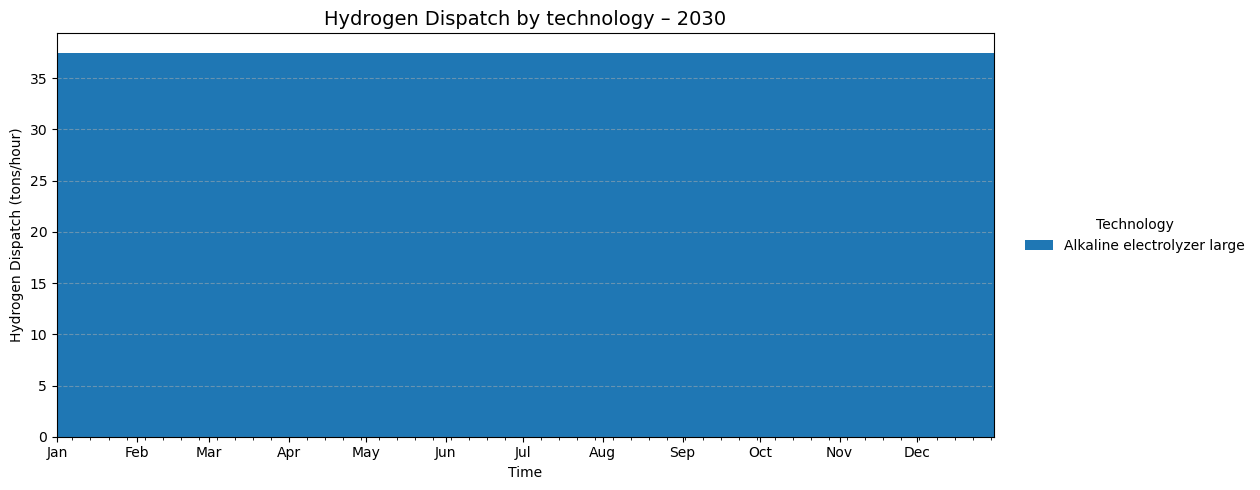

In [43]:
hydrogen_dispatch_df = plot_hydrogen_dispatch(networks, h2_carriers)

### 5.3.1. Hourly matching

Skipping 2023: no hourly matching implemented.



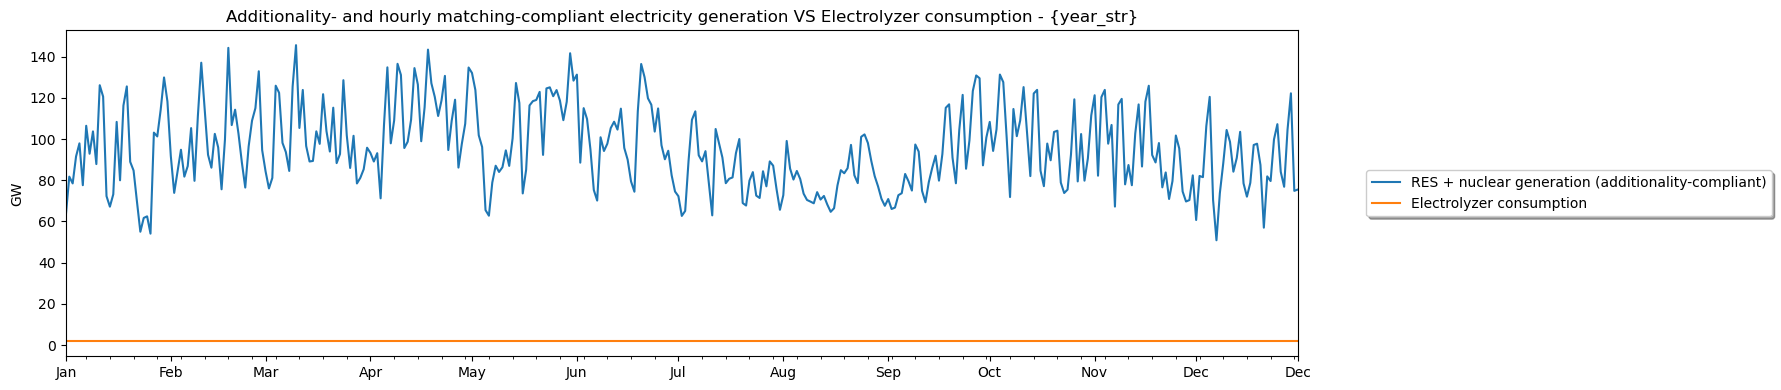

In [44]:
for idx, (network_name, network) in enumerate(networks.items()):    
    year_str = network_name.split("_")[-1]

    # skip 2023 because hourly matching is not implemented
    if year_str == "2023":
        print("Skipping 2023: no hourly matching implemented.\n")
        continue

    # define additionality requirement
    additionality = True

    # calculate electrolyzers consumption
    electrolysis_carrier = [
        'H2 Electrolysis',
        'Alkaline electrolyzer large',
        'Alkaline electrolyzer medium',
        'Alkaline electrolyzer small',
        'PEM electrolyzer',
        'SOEC'
    ]

    electrolyzers = network.links[network.links.carrier.isin(electrolysis_carrier)].index
    electrolyzers_consumption = network.links_t.p0[electrolyzers].multiply(
        network.snapshot_weightings.objective, axis=0
    ).sum(axis=1)

    # calculate RES + nuclear generation
    res_carriers = [
        "csp",
        "solar",
        "onwind",
        "offwind-ac",
        "offwind-dc",
        "ror",
        "nuclear",
    ]
    res_stor_techs = ["hydro"]

    # get RES generators and storage units
    res_gens = network.generators.query("carrier in @res_carriers").index
    res_storages = network.storage_units.query("carrier in @res_stor_techs").index

    if additionality:
        # get new generators and storage_units
        new_gens = network.generators.loc[
            network.generators.build_year == int(year_str)
        ].index
        new_stor = network.storage_units.loc[
            network.storage_units.build_year == int(year_str)
        ].index
        # keep only new RES generators and storage units
        res_gens = res_gens.intersection(new_gens)
        res_storages = res_storages.intersection(new_stor)

    # calculate RES + nuclear generation (only additionality-compliant)
    res_generation = network.generators_t.p[res_gens].multiply(
        network.snapshot_weightings.objective, axis=0
    ).sum(axis=1)
    res_storages_dispatch = network.storage_units_t.p[res_storages].multiply(
        network.snapshot_weightings.objective, axis=0
    ).sum(axis=1)
    res_generation_total = res_generation + res_storages_dispatch

    compare_df = pd.concat([res_generation_total, electrolyzers_consumption], axis=1)
    compare_df.rename(
        columns={0: "RES + nuclear generation (additionality-compliant)",
                 1: "Electrolyzer consumption"},
        inplace=True
    )

    fig, ax = plt.subplots(figsize=(18, 4))
    (
        compare_df[
            ["RES + nuclear generation (additionality-compliant)", "Electrolyzer consumption"]
        ]
        .div(network.snapshot_weightings.objective, axis=0)
        .div(1e3).resample("D").mean().plot(ax=ax)
    )
    ax.set_ylabel("GW")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    ax.set_xlabel(None)
    ax.set_title("Additionality- and hourly matching-compliant electricity generation VS Electrolyzer consumption - {year_str}")
    
    ax.legend(
        loc="center left",
        bbox_to_anchor=(1.05, 0.5),
        frameon=True,
        fancybox=True,
        shadow=True
    )
    
    plt.tight_layout()

### 5.3.2. Hydrogen VS e-kerosene production


Skipped 2023: both daily-average productions are below 1.0 MW.



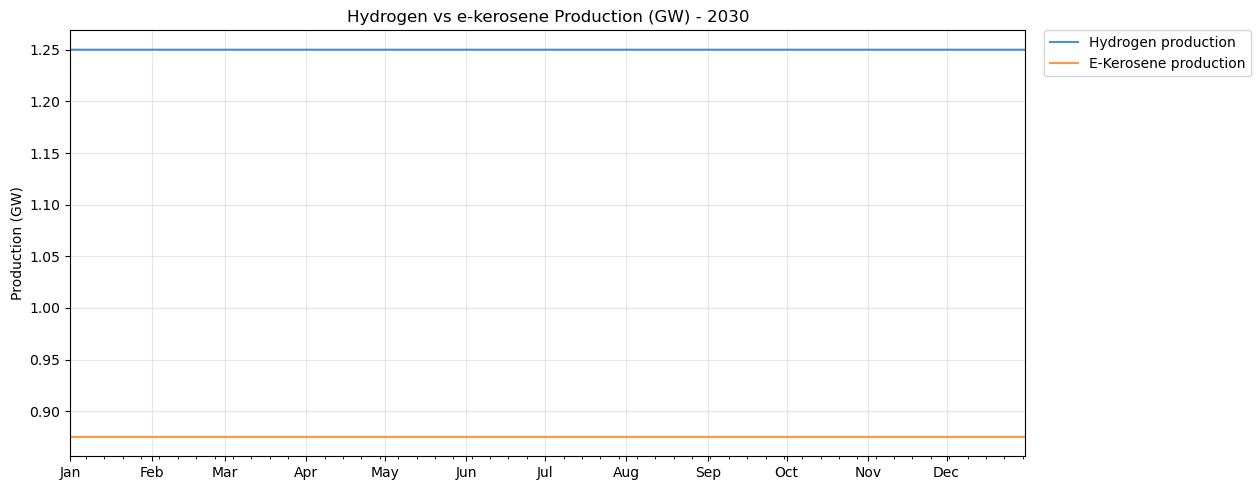

In [45]:
hydrogen_ekerosene_prod = {}
for name, net in networks.items():
    year = name[-4:]
    hydrogen_ekerosene_prod[name] = compare_h2_kerosene_production(net, network_name=year)

In [46]:
h2_capacity_factors = {}

print("\nCapacity factor for H2 production\n")
for name, net in networks.items():
    year = name[-4:]

    # compute CF for this network
    results = compute_capacity_factor_electrolysis({year: net})
    h2_capacity_factors[name] = results

    for y, df in results.items():
        # filter regions with negligible capacity
        df_filtered = df[df["Capacity (GW input electricity)"] >= 1e-3].copy()
        if df_filtered.empty:
            continue

        df_filtered.reset_index(drop=True, inplace=True)

        print(f"\nYear: {year}\n")
        display(
            df_filtered.style
            .hide(axis="index")
            .format({
                "Capacity (GW input electricity)": "{:.2f}",
                "Electricity input (MWh)": "{:.0f}",
                "Hydrogen output (MWh)": "{:.0f}",
                "Capacity factor (%)": "{:.2f}",  # show as % with 2 decimals
            })
        )



Capacity factor for H2 production


Year: 2030



---

## 6. Economic Analysis

*This section shows the evolution of levelized costs of electricity and hydrogen throughout the model time horizon.*

### 6.1. Levelized Cost of Electricity (LCOE)
*The LCOE is assessed at the level of the different US grid regions.*

In [47]:
grid_regions_shapes = gpd.read_file(grid_region_shapes_path)

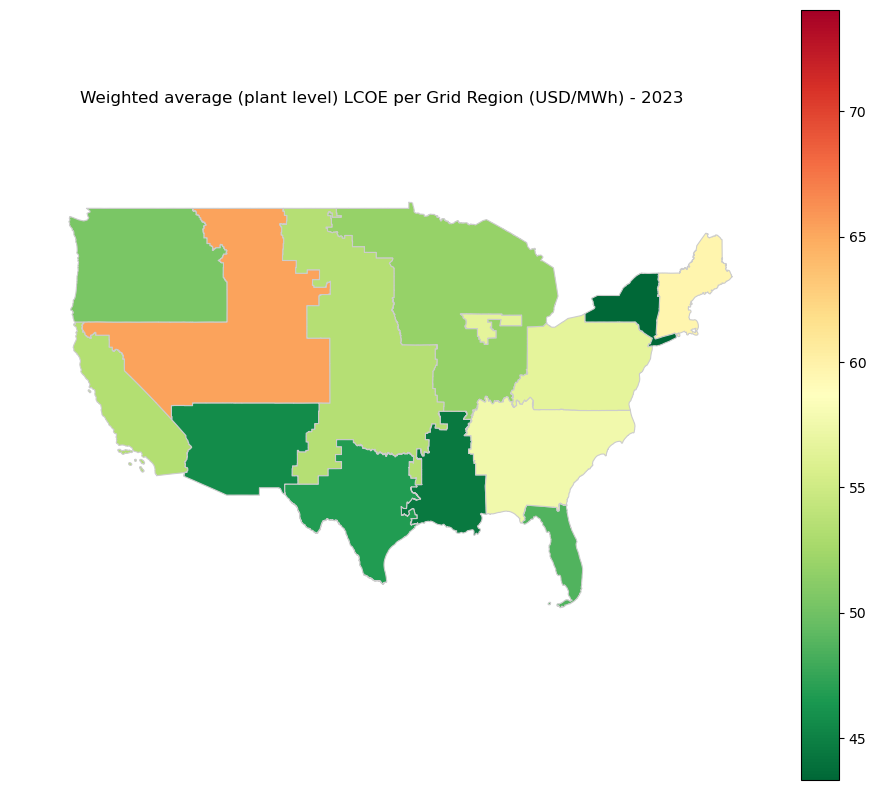

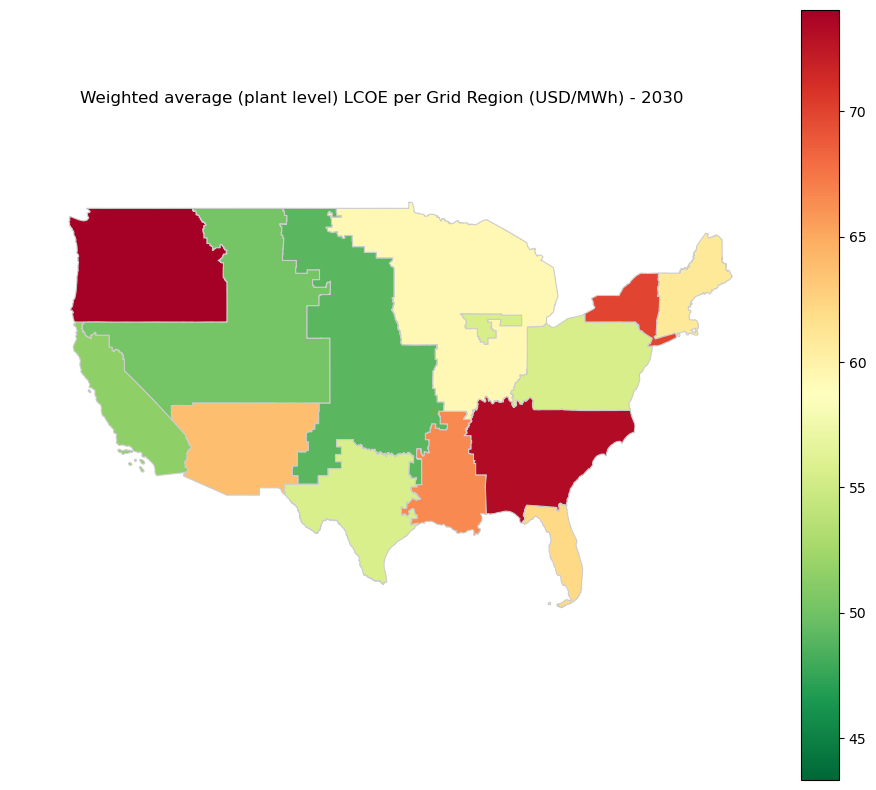

In [48]:
# Collect LCOE values and cache results
all_weighted_lcoe = []
cached_results = {}

for key, net in networks.items():
    lcoe_gdf, table, lcoe_by_bus, lcoe_data, *_ = calculate_lcoe_summary_and_map(net, grid_regions_shapes)
    cached_results[key] = (net, lcoe_gdf, table, lcoe_by_bus, lcoe_data)

    # Map EMM regions and transmission fees
    # emm_mapping = dict(zip(net.buses.grid_region, net.buses.emm_region))
    table["EMM Region"] = table["grid_region"].map(emm_mapping)

    fee_map = regional_fees.loc[
        regional_fees["Year"] == int(key.split("_")[-1]), ["region", "Transmission nom USD/MWh", "Distribution nom USD/MWh"]
    ].set_index("region")[["Transmission nom USD/MWh", "Distribution nom USD/MWh"]]

    table["Transmission (USD/MWh)"] = table["EMM Region"].map(fee_map.loc[:,"Transmission nom USD/MWh"])
    table["Distribution (USD/MWh)"] = table["EMM Region"].map(fee_map.loc[:,"Distribution nom USD/MWh"])
    table.drop(columns=["EMM Region"], inplace=True)

    table.loc[:,"LCOE_transmission_fees (USD/MWh)"] = table.loc[:,"Weighted Average LCOE (USD/MWh)"] + table.loc[:, "Transmission (USD/MWh)"]
    table.loc[:,"LCOE_transmission_distribution_fees (USD/MWh)"] =  table.loc[:,"LCOE_transmission_fees (USD/MWh)"] + table.loc[:, "Distribution (USD/MWh)"]

    merged = lcoe_by_bus.merge(lcoe_data[['bus', 'energy']], on='bus', how='left')
    grouped = merged.groupby('grid_region').apply(
        lambda df: (df['weighted_lcoe'] * df['energy']).sum() / df['energy'].sum()
    )
    all_weighted_lcoe.extend(grouped.dropna().values)

# Compute global vmin/vmax
vmin = np.quantile(all_weighted_lcoe, 0.05)
vmax = np.quantile(all_weighted_lcoe, 0.95)

# Plot using cached data
plots_data = {}

for key, (net, lcoe_gdf, table, lcoe_by_bus, lcoe_data) in cached_results.items():
    year_match = re.search(r'\d{4}', key)
    year_str = year_match.group() if year_match else "Year N/A"
    title = f"Weighted average (plant level) LCOE per Grid Region (USD/MWh) - {year_str}"

    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    plots_data[key] = table

    plot_lcoe_map_by_grid_region(
        lcoe_by_bus, lcoe_data, grid_regions_shapes,
        title=title, key=key, ax=ax,
        vmin=vmin, vmax=vmax
    )

    plt.show()


In [49]:
def uppercase_only_lcoe_word(df):
    new_cols = {
        col: re.sub(r'\blcoe\b', 'LCOE', col, flags=re.IGNORECASE)
        for col in df.columns
    }
    return df.rename(columns=new_cols)

def apply_nice_names_to_columns_custom(df, mapping):
    sorted_mapping = sorted(mapping.items(), key=lambda item: -len(item[0]))

    placeholder_prefix = "__PLACEHOLDER__"
    placeholder_map = {}
    
    new_cols = []
    for col in df.columns:
        temp_col = col
        for i, (key, val) in enumerate(sorted_mapping):
            if key in temp_col:
                placeholder = f"{placeholder_prefix}{i}__"
                placeholder_map[placeholder] = val
                temp_col = temp_col.replace(key, placeholder)
        new_cols.append(temp_col)
    
    final_cols = [
        reduce(lambda c, p: c.replace(p[0], p[1]), placeholder_map.items(), col)
        for col in new_cols
    ]
    
    df.columns = final_cols
    return df

for net_name, table in plots_data.items():
    year = net_name[-4:]
    print(f"\nYear: {year}")

    if table.index.name == "grid_region":
        table = table.reset_index()

    table = table.rename(columns={"grid_region": "Grid Region"})
    table = table.rename(columns={"Transmission (USD/MWh)": "Transmission fees (USD/MWh)"})
    table = table.rename(columns={"Distribution (USD/MWh)": "Distribution fees (USD/MWh)"})
    table = table.rename(columns={"LCOE_transmission_fees (USD/MWh)": "LCOE + Transmission fees (USD/MWh)"})
    table = table.rename(columns={"LCOE_transmission_distribution_fees (USD/MWh)": "LCOE + T&D fees (USD/MWh)"})

    table.index = pd.Index([""] * len(table))

    table = uppercase_only_lcoe_word(table)
    table = apply_nice_names_to_columns_custom(table, nice_names)

    display(
        table.style.format(precision=2, thousands=",")
    )


Year: 2023



Year: 2030


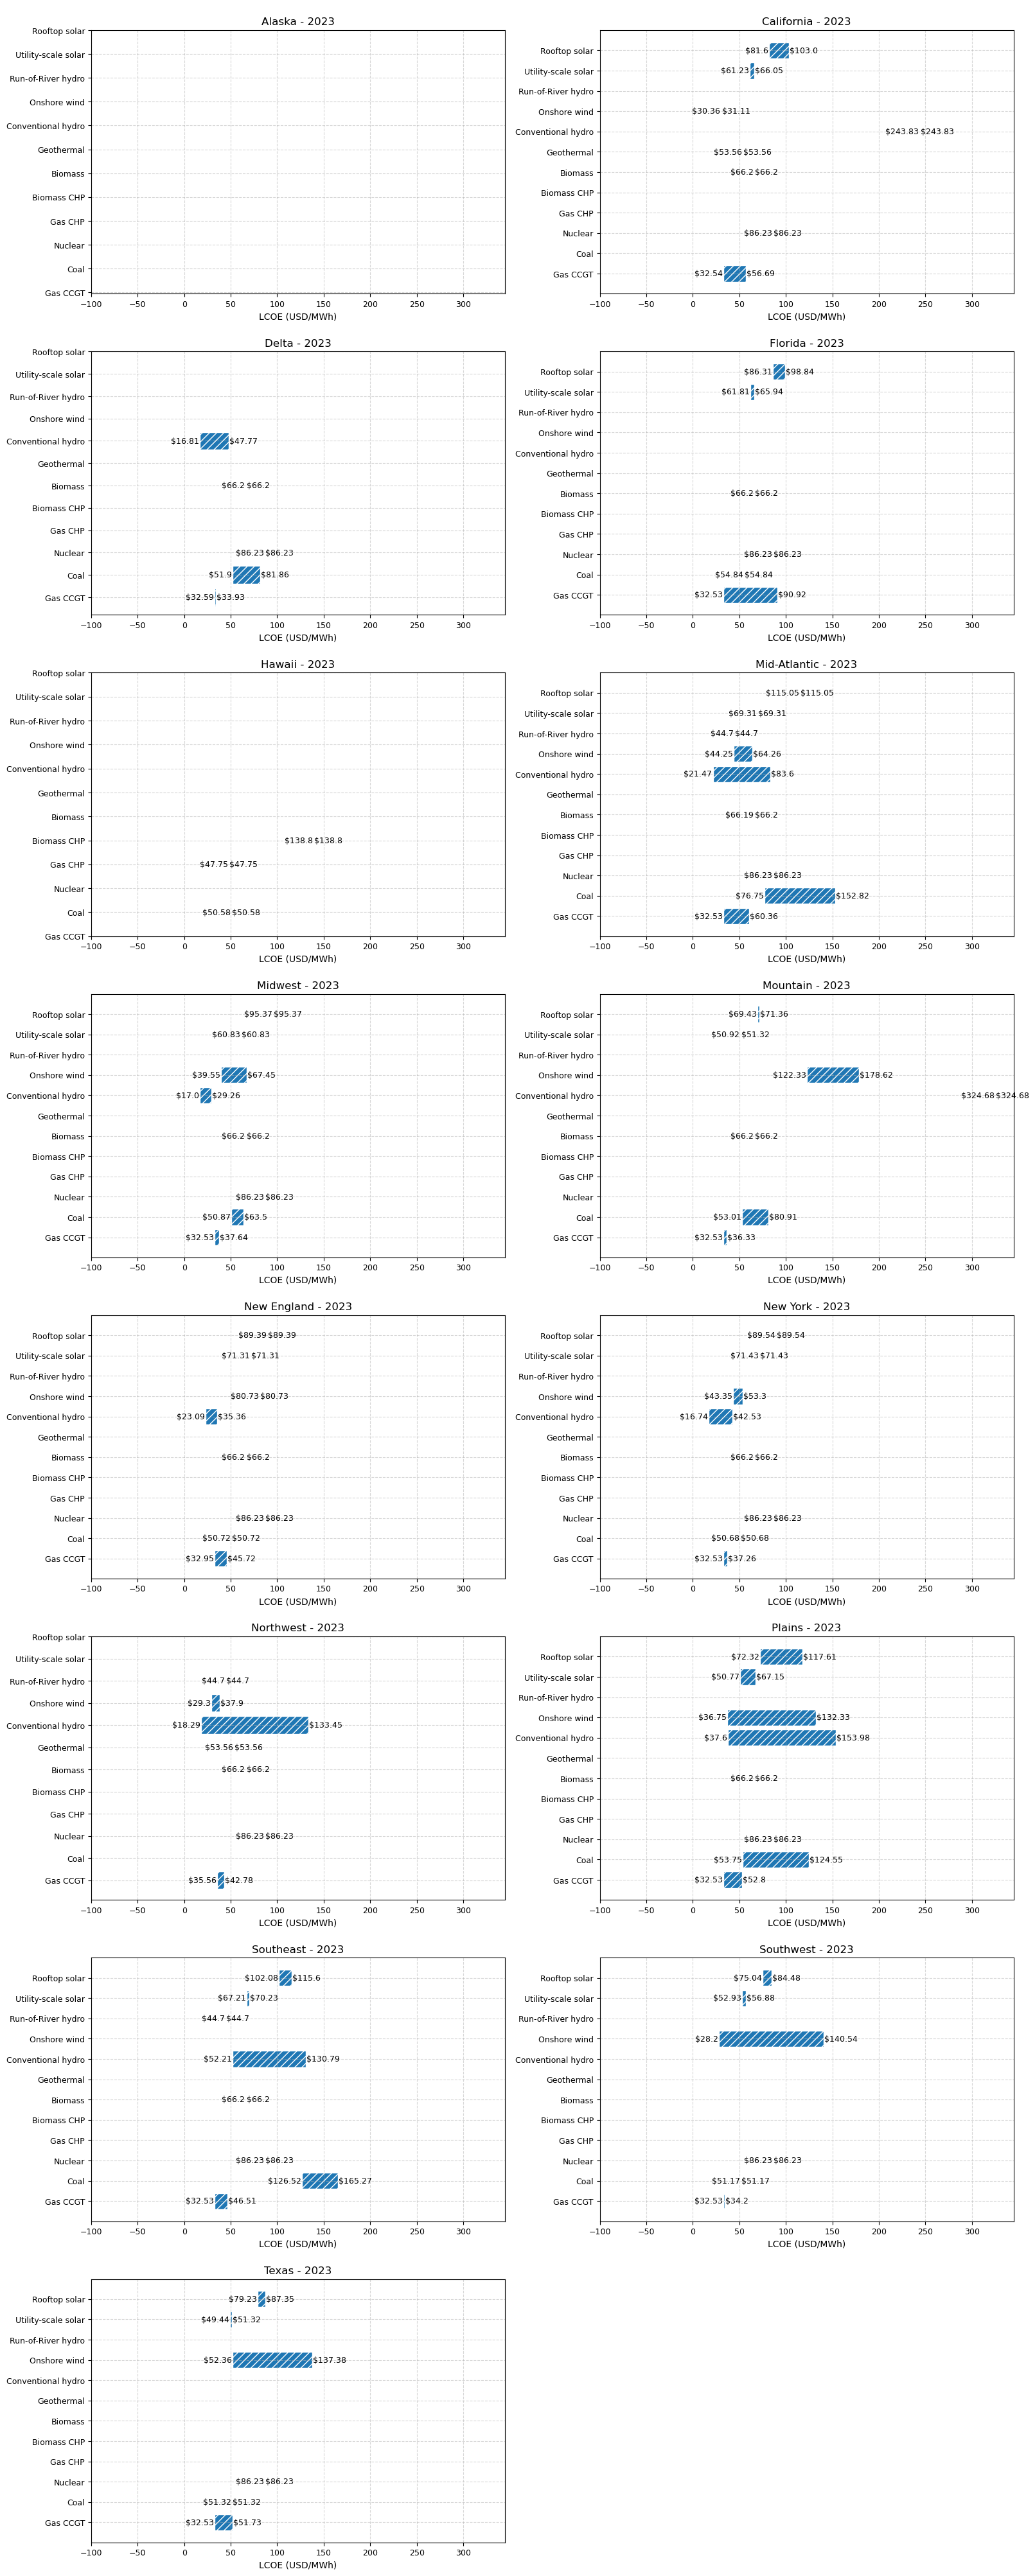

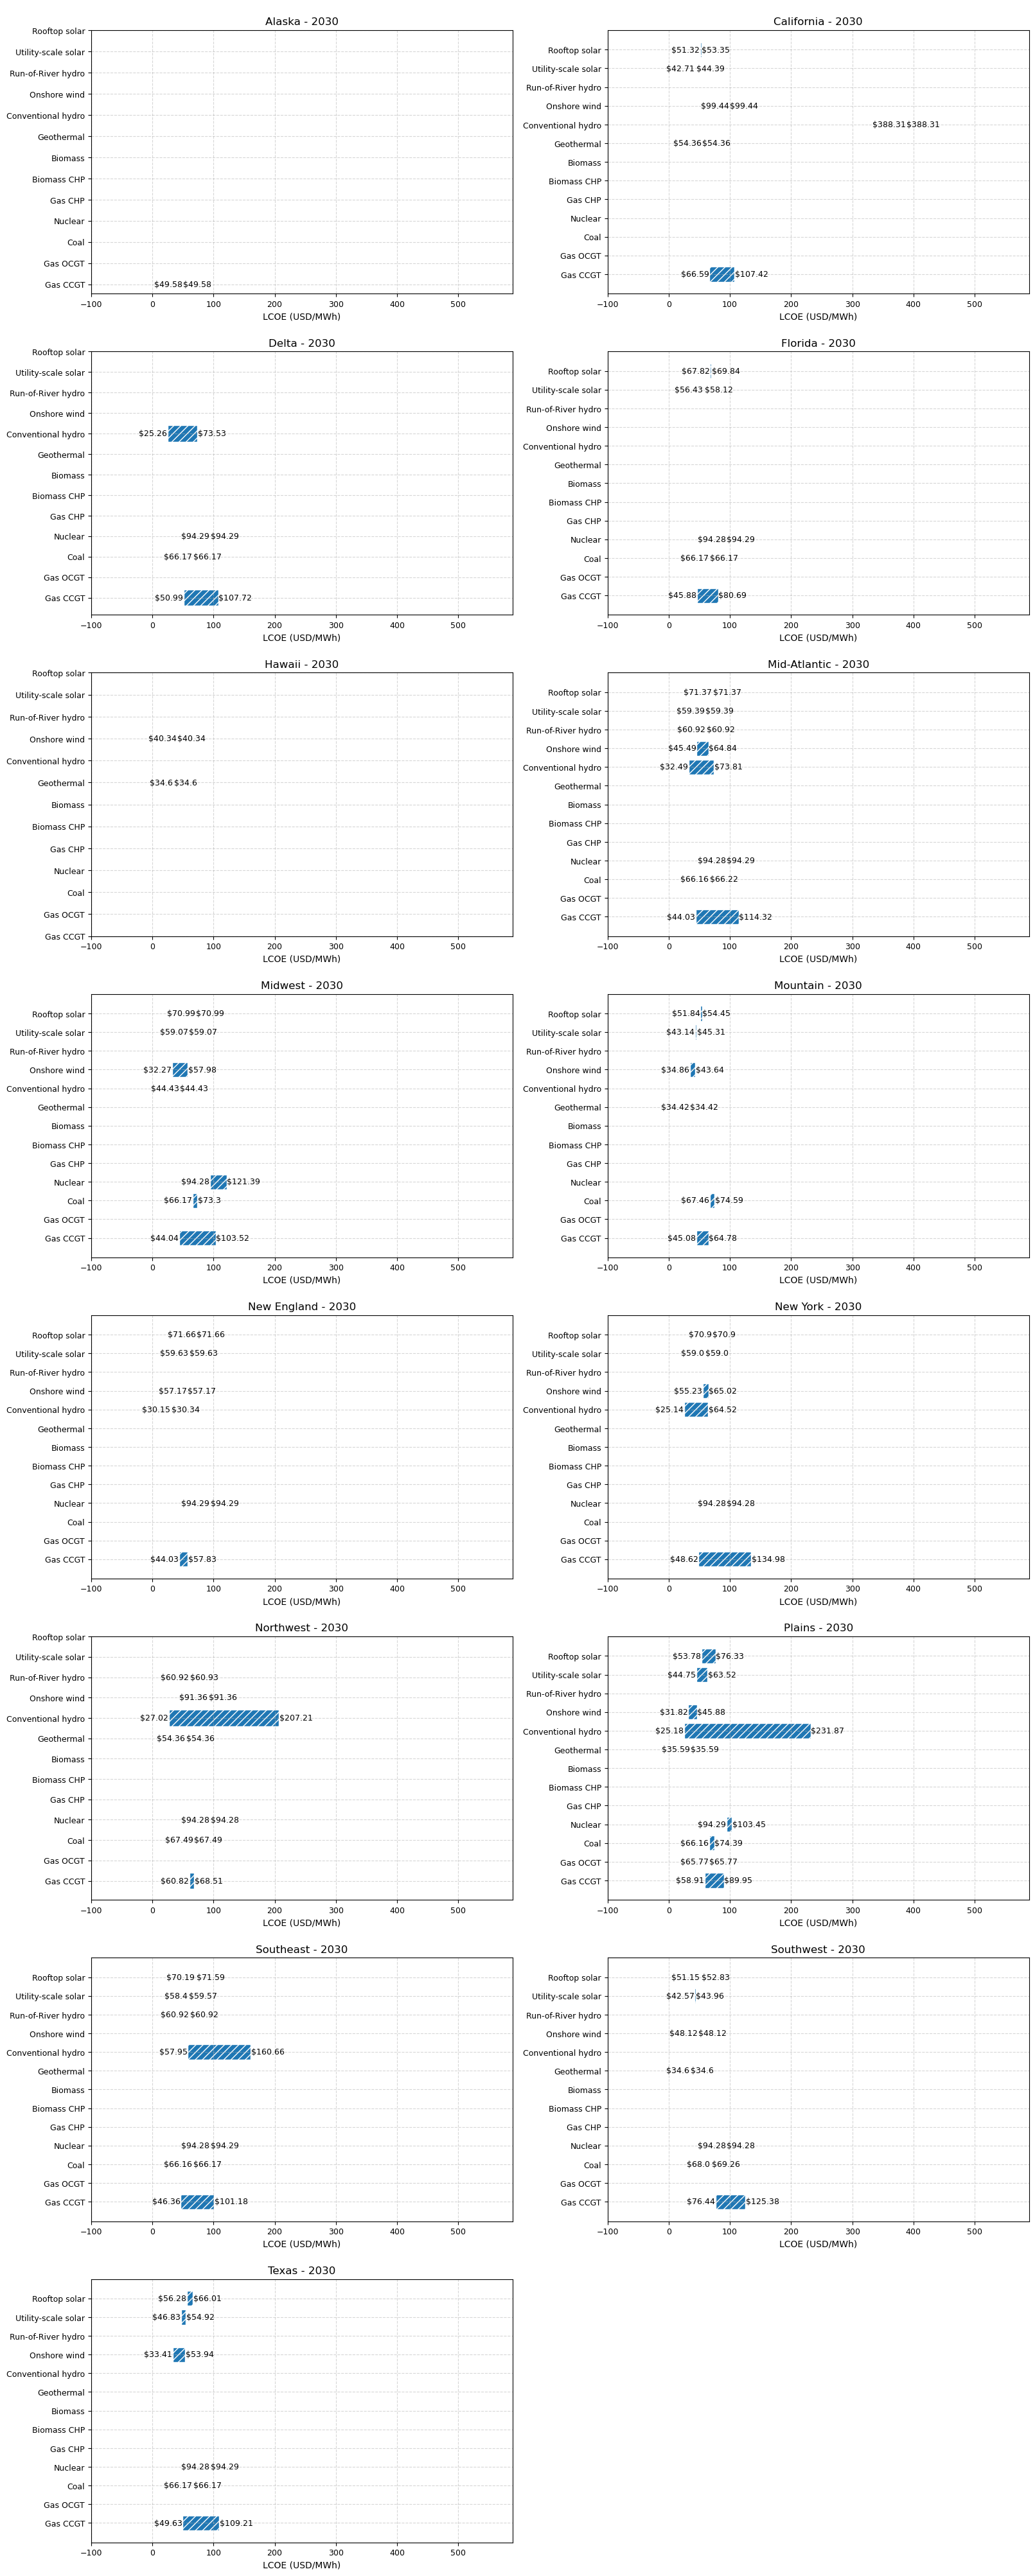

In [50]:
for key, net in networks.items():
    _, _, _, lcoe_data, *_ = calculate_lcoe_summary_and_map(net, grid_regions_shapes)

    region_summary = lcoe_data.groupby(['grid_region', 'bus', 'carrier']).agg(
            dispatch_mwh=('energy', 'sum'),
            total_cost=('lcoe', lambda x: (x * lcoe_data.loc[x.index, 'energy']).sum())
        ).reset_index()

    region_summary['lcoe'] = region_summary['total_cost'] / region_summary['dispatch_mwh']
    region_summary['dispatch'] = region_summary['dispatch_mwh'] / 1e6
    region_summary['bus'] = region_summary['bus'].str.extract(r'(US\d{1} \d{1,2})')

    region_bus_summary = region_summary.pivot(index=['grid_region', 'bus'], columns='carrier', values=['lcoe', 'dispatch'])
    region_bus_summary.columns = [
        f"{carrier} {metric} ({'USD/MWh' if metric == 'lcoe' else 'TWh'})"
        for metric, carrier in region_bus_summary.columns
    ]
    region_bus_summary = region_bus_summary.reset_index()

    dispatch_cols = [col for col in region_bus_summary.columns if 'dispatch' in col.lower()]
    for col in dispatch_cols:
        region_bus_summary[col] = pd.to_numeric(region_bus_summary[col], errors='coerce').fillna(0.0)

    lcoe_cols = [col for col in region_bus_summary.columns if 'lcoe' in col.lower()]

    min_dispatch_threshold = 1  # TWh
    for lcoe_col in lcoe_cols:
        carrier = lcoe_col.split(" ")[0]
        dispatch_col = next((col for col in dispatch_cols if col.startswith(carrier + " ")), None)
        if dispatch_col:
            mask = region_bus_summary[dispatch_col] < min_dispatch_threshold
            region_bus_summary.loc[mask, lcoe_col] = np.nan
    
    table_df = region_bus_summary.groupby(['grid_region']).agg(['min', 'max']).drop(columns=['bus'])

    plot_float_bar_lcoe_dispatch_ranges(table_df, key, nice_names)



**Note:** The LCOE values reported here also include existing nuclear plants, many of which are already amortized and were built under different historical cost conditions. In contrast, Lazard’s estimates reflect newly built projects with current capital costs and construction standards, which explains the higher LCOE values.

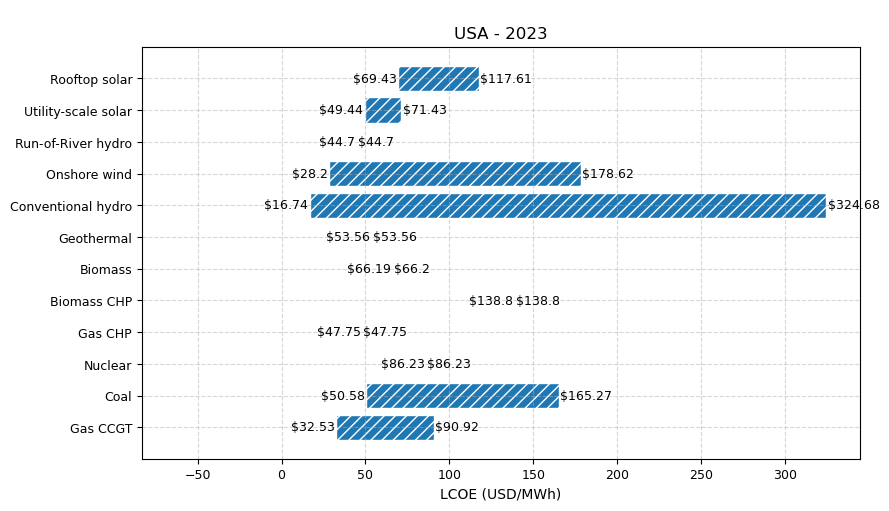


**Note:** The LCOE values reported here also include existing nuclear plants, many of which are already amortized and were built under different historical cost conditions. In contrast, Lazard’s estimates reflect newly built projects with current capital costs and construction standards, which explains the higher LCOE values.

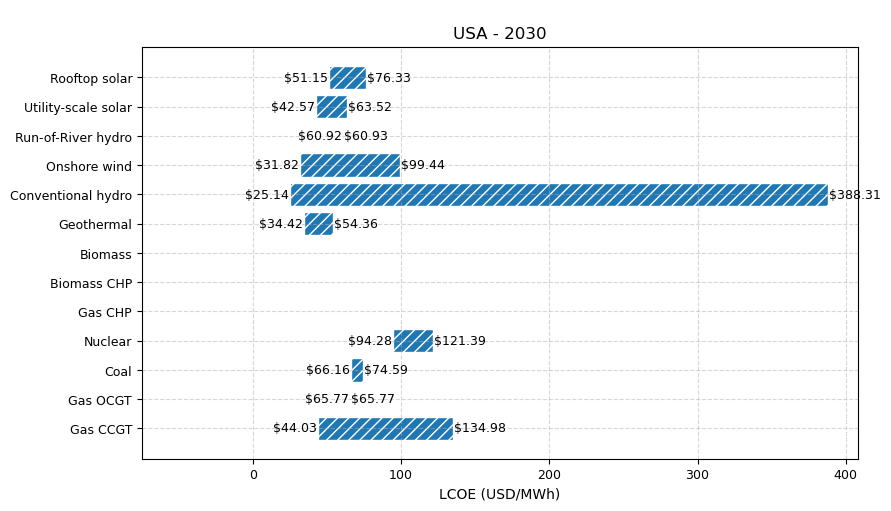

In [51]:
for key, net in networks.items():
    # Recalculate lcoe_data and region_bus_summary
    _, _, _, lcoe_data, *_ = calculate_lcoe_summary_and_map(net, grid_regions_shapes)

    region_summary = lcoe_data.groupby(['grid_region', 'bus', 'carrier']).agg(
        dispatch_mwh=('energy', 'sum'),
        total_cost=('lcoe', lambda x: (x * lcoe_data.loc[x.index, 'energy']).sum())
    ).reset_index()

    region_summary['lcoe'] = region_summary['total_cost'] / region_summary['dispatch_mwh']
    region_summary['dispatch'] = region_summary['dispatch_mwh'] / 1e6
    region_summary['bus'] = region_summary['bus'].str.extract(r'(US\d{1} \d{1,2})')

    region_bus_summary = region_summary.pivot(index=['grid_region', 'bus'], columns='carrier', values=['lcoe', 'dispatch'])
    region_bus_summary.columns = [
        f"{carrier} {metric} ({'USD/MWh' if metric == 'lcoe' else 'TWh'})"
        for metric, carrier in region_bus_summary.columns
    ]
    region_bus_summary = region_bus_summary.reset_index()

    # Convert dispatch to numeric and apply threshold filtering to LCOE
    dispatch_cols = [col for col in region_bus_summary.columns if 'dispatch' in col.lower()]
    lcoe_cols = [col for col in region_bus_summary.columns if 'lcoe' in col.lower()]
    
    for col in dispatch_cols:
        region_bus_summary[col] = pd.to_numeric(region_bus_summary[col], errors='coerce').fillna(0.0)

    min_dispatch_threshold = 1  # TWh
    for lcoe_col in lcoe_cols:
        carrier = lcoe_col.split(" ")[0]
        dispatch_col = next((col for col in dispatch_cols if col.startswith(carrier + " ")), None)
        if dispatch_col:
            mask = region_bus_summary[dispatch_col] < min_dispatch_threshold
            region_bus_summary.loc[mask, lcoe_col] = np.nan

    # --- NATIONAL PLOT ONLY ---
    national_data = region_bus_summary.drop(columns=['grid_region', 'bus'])
    lcoe_columns = [col for col in national_data.columns if 'lcoe' in col.lower()]
    national_data = national_data[lcoe_columns]

    national_min = national_data.min()
    national_max = national_data.max()

    arrays = [[col for col in national_min.index] * 2, ['min'] * len(national_min) + ['max'] * len(national_max)]
    multi_cols = pd.MultiIndex.from_tuples(zip(*arrays))

    national_values = pd.concat([national_min, national_max])
    national_df = pd.DataFrame([national_values.values], columns=multi_cols, index=['USA'])

    display(Markdown("\n**Note:** The LCOE values reported here also include existing nuclear plants, many of which are already amortized and were built under different historical cost conditions. In contrast, Lazard’s estimates reflect newly built projects with current capital costs and construction standards, which explains the higher LCOE values."))
    plot_float_bar_lcoe_dispatch_ranges(national_df, key, nice_names)


### 6.2. Levelized Cost of Hydrogen (LCOH)
*The levelized cost of hydrogen is assessed at the level of the different US Grid Regions.*

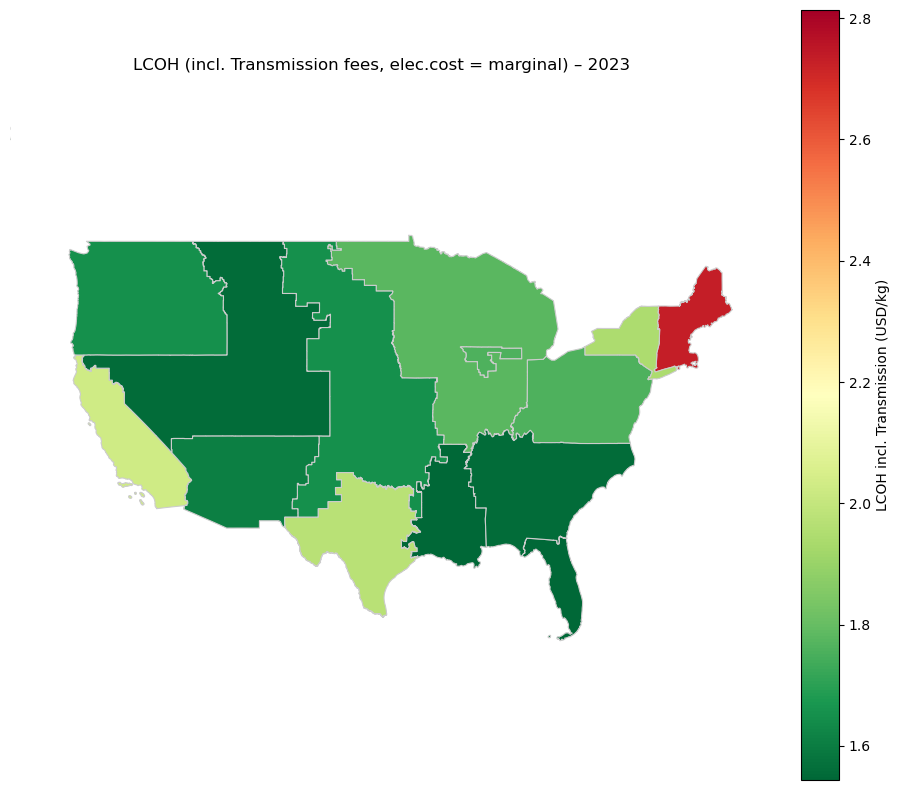

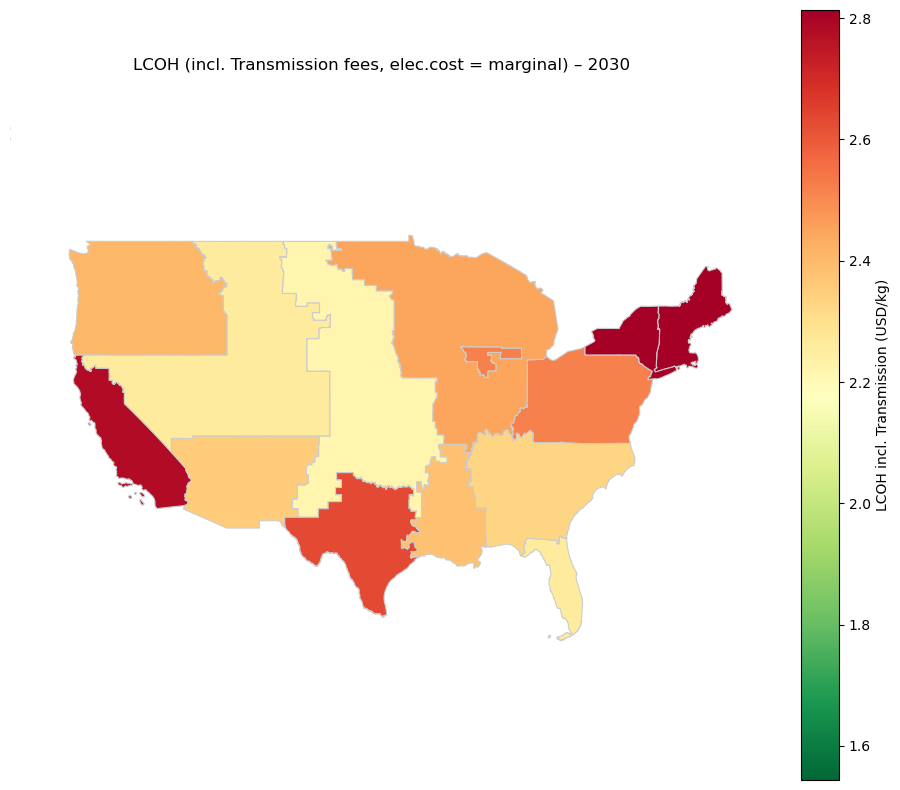

In [52]:
## Using Marginal price as electricity price
plot_lcoh_maps_by_grid_region_marginal(
    networks,
    grid_regions_shapes,
    h2_carriers,
    regional_fees,
    emm_mapping,
    output_threshold=0
)

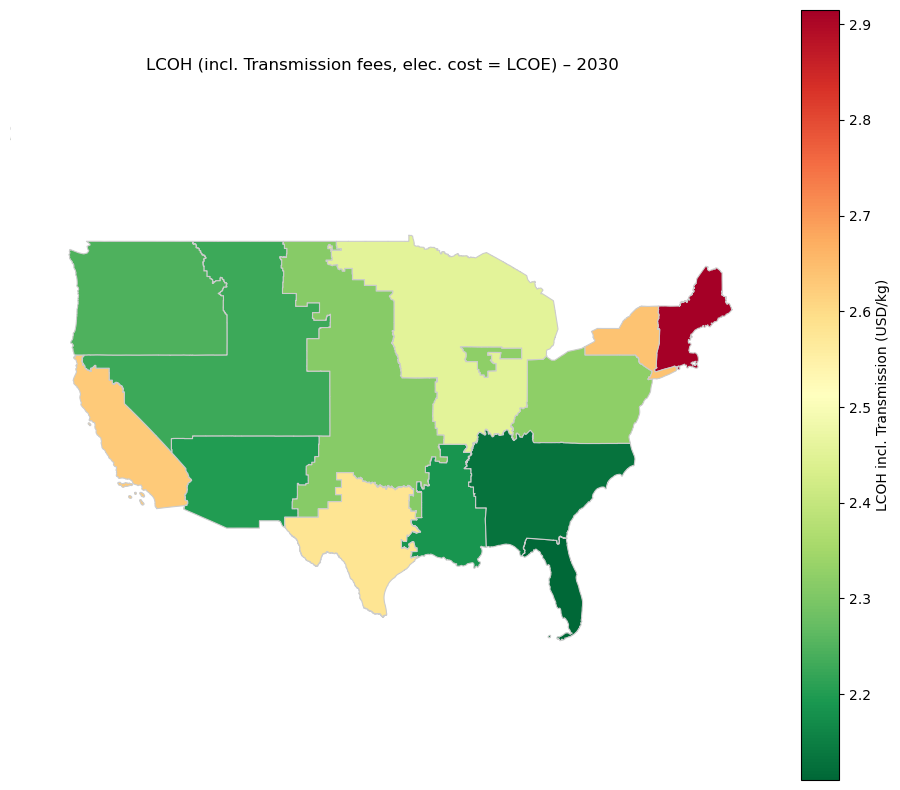

In [53]:
lcoe_gdf, table, lcoe_by_bus, lcoe_data, vmin, vmax = calculate_lcoe_summary_and_map(
    n, grid_regions_shapes
)

# Using LCOE as electricity cost
plot_lcoh_maps_by_grid_region_lcoe(
    networks=networks,
    shapes=grid_regions_shapes,
    h2_carriers=h2_carriers,
    regional_fees=regional_fees,
    emm_mapping=emm_mapping,
    output_threshold=0
)


In [54]:
# LCOH using marginal price as electricity price
res_marginal = calculate_lcoh_by_region(
    networks,
    h2_carriers,
    regional_fees,
    emm_mapping,
    electricity_price="marginal"
)

print("\nLCOH using marginal price as electricity price")
for year, df in res_marginal.items():
    print(f"\nYear {year}:")
    
    # format only numeric columns
    numeric_cols = df.select_dtypes(include="number").columns
    fmt = {col: "{:.2f}" for col in numeric_cols}
    
    display(df.style.format(fmt).hide(axis="index"))



LCOH using marginal price as electricity price

Year 2023:



Year 2030:


In [55]:
# Compute LCOE per bus and per region
lcoe_gdf, table, lcoe_by_bus, lcoe_data, vmin, vmax = calculate_lcoe_summary_and_map(
    n, regions_onshore
)

# Weighted average LCOE per grid region (USD/MWh el)
grid_region_weighted_lcoe = (
    lcoe_by_bus.merge(lcoe_data[['bus', 'energy']], on='bus', how='left')
    .groupby('grid_region')
    .apply(lambda df: (df['weighted_lcoe'] * df['energy']).sum() / df['energy'].sum())
)

# LCOH using LCOE as electricity price
res_lcoe = calculate_lcoh_by_region(
    networks,
    h2_carriers,
    regional_fees,
    emm_mapping,
    electricity_price="LCOE",
    grid_region_lcoe=grid_region_weighted_lcoe
)

print("\nLCOH using LCOE as electricity price")
for year, df in res_lcoe.items():
    print(f"\nYear {year}:")
    
    # format only numeric columns
    numeric_cols = df.select_dtypes(include="number").columns
    fmt = {col: "{:.2f}" for col in numeric_cols}
    
    display(df.style.format(fmt).hide(axis="index"))



LCOH using LCOE as electricity price

Year 2023:



Year 2030:


---

## 7. E-Kerosene

*This section is dedicated to the analysis of e-kerosene production and costs.*

## 7.1. Aviation fuel demand

In [56]:
df = compute_aviation_fuel_demand(networks)

styled_df = (
    df.style
    .hide(axis="index")  # hide index
    .format({
        "Kerosene (TWh)": "{:,.2f}",
        "e-Kerosene (TWh)": "{:,.2f}",
        "Total (TWh)": "{:,.2f}",
        "e-Kerosene Share (%)": "{:.1f}%",
    })
    .set_properties(**{"text-align": "right", "font-size": "13px"})
    .set_table_styles([
        {"selector": "th", "props": [("text-align", "right"), ("font-size", "12px")]},
        {"selector": "caption", "props": [("caption-side", "top"), ("font-weight", "bold"), ("font-size", "16px")]}
    ])
)

print("\nAviation fuel demand\n")
display(styled_df)


Aviation fuel demand



In [57]:
passenger_data = pd.read_csv("T100_Domestic_Market_and_Segment_Data_-3591723781169319541.csv")
total_passengers = passenger_data.passengers.sum()

In [58]:
for network_name, n in networks.items():
    print(f"\nYear: {network_name[-4:]}\n")
    ekerosene_demand_state = compute_aviation_demand_table(n)
    ekerosene_demand_state.loc[:, "n. of Passengers"] = (
        ekerosene_demand_state["Share (%)"] * total_passengers / 100)
    display(ekerosene_demand_state.set_index("State")[["Fuel demand (TWh)", "n. of Passengers", "Share (%)"]])


Year: 2023



Fuel demand (TWh)  n. of Passengers  Share (%)
State                                                
CA            151.273442      1.249467e+08  15.072359
NY            110.988560      9.167279e+07  11.058514
FL             94.428460      7.799471e+07   9.408523
TX             90.252859      7.454580e+07   8.992481
IL             52.619653      4.346205e+07   5.242839
GA             36.554056      3.019241e+07   3.642119
MD             30.571404      2.525094e+07   3.046028
WA             29.712894      2.454184e+07   2.960489
SC             27.255712      2.251229e+07   2.715664
KY             25.470124      2.103746e+07   2.537755
TN             25.037402      2.068004e+07   2.494640
HI             24.984185      2.063609e+07   2.489337
KS             24.831557      2.051002e+07   2.474130
MA             24.376261      2.013397e+07   2.428766
AZ             23.050263      1.903874e+07   2.296648
CO             22.638701      1.869880e+07   2.255641
PA             22.565071      1.863798e+07   2.248305
NV             21.597947      1.783917e+07   2.151944
AK             19.895750      1.643321e+07   1.982343
VA             14.134698      1.167478e+07   1.408332
OH             14.112708      1.165662e+07   1.406141
MN             14.028841      1.158735e+07   1.397785
OK             13.909363      1.148866e+07   1.385881
MI             13.735298      1.134489e+07   1.368537
UT             12.708648      1.049691e+07   1.266246
OR              8.337620      6.886591e+06   0.830731
IN              6.555310      5.414464e+06   0.653148
NC              6.366769      5.258735e+06   0.634363
ID              5.845996      4.828595e+06   0.582475
LA              5.746073      4.746061e+06   0.572519
NM              4.833958      3.992685e+06   0.481639
AL              4.756460      3.928675e+06   0.473917
MO              3.593177      2.967842e+06   0.358012
IA              2.923027      2.414321e+06   0.291240
MT              2.510995      2.073997e+06   0.250187
AR              2.461200      2.032868e+06   0.245225
NE              1.845335      1.524184e+06   0.183863
WI              1.603012      1.324034e+06   0.159719
MS              1.580606      1.305527e+06   0.157486
ME              1.546780      1.277588e+06   0.154116
ND              1.447371      1.195479e+06   0.144211
SD              0.436694      3.606940e+05   0.043511
WV              0.335494      2.771070e+05   0.033427
WY              0.188328      1.555527e+05   0.018764
NH              0.000000      0.000000e+00   0.000000


Year: 2030



Fuel demand (TWh)  n. of Passengers  Share (%)
State                                                
CA            165.063486      1.249467e+08  15.072359
NY            121.106245      9.167279e+07  11.058514
FL            103.036531      7.799471e+07   9.408523
TX             98.480284      7.454580e+07   8.992481
IL             57.416446      4.346205e+07   5.242839
GA             39.886313      3.019241e+07   3.642119
MD             33.358285      2.525094e+07   3.046028
WA             32.421513      2.454184e+07   2.960489
SC             29.740335      2.251229e+07   2.715664
KY             27.791974      2.103746e+07   2.537755
TN             27.319804      2.068004e+07   2.494640
HI             27.261736      2.063609e+07   2.489337
MA             26.598394      2.013397e+07   2.428766
AZ             25.151518      1.903874e+07   2.296648
KS             25.072290      1.897876e+07   2.289413
CO             24.702438      1.869880e+07   2.255641
PA             24.622097      1.863798e+07   2.248305
NV             23.566809      1.783917e+07   2.151944
AK             22.765478      1.723259e+07   2.078773
VA             16.390081      1.240666e+07   1.496619
OH             15.399218      1.165662e+07   1.406141
MN             15.307706      1.158735e+07   1.397785
OK             15.177337      1.148866e+07   1.385881
MI             14.987403      1.134489e+07   1.368537
UT             13.867165      1.049691e+07   1.266246
OR              9.097675      6.886591e+06   0.830731
IN              7.152890      5.414464e+06   0.653148
NC              6.947162      5.258735e+06   0.634363
ID              6.378916      4.828595e+06   0.582475
LA              6.269883      4.746061e+06   0.572519
NM              5.274620      3.992685e+06   0.481639
AL              5.190058      3.928675e+06   0.473917
MO              3.920730      2.967842e+06   0.358012
IA              3.189490      2.414321e+06   0.291240
MT              2.739896      2.073997e+06   0.250187
AR              2.685563      2.032868e+06   0.245225
NE              2.013555      1.524184e+06   0.183863
WI              1.749142      1.324034e+06   0.159719
MS              1.724694      1.305527e+06   0.157486
ME              1.687784      1.277588e+06   0.154116
ND              1.579313      1.195479e+06   0.144211
SD              0.476502      3.606940e+05   0.043511
WV              0.366078      2.771070e+05   0.033427
WY              0.205496      1.555527e+05   0.018764
NH              0.000000      0.000000e+00   0.000000


Year: 2023



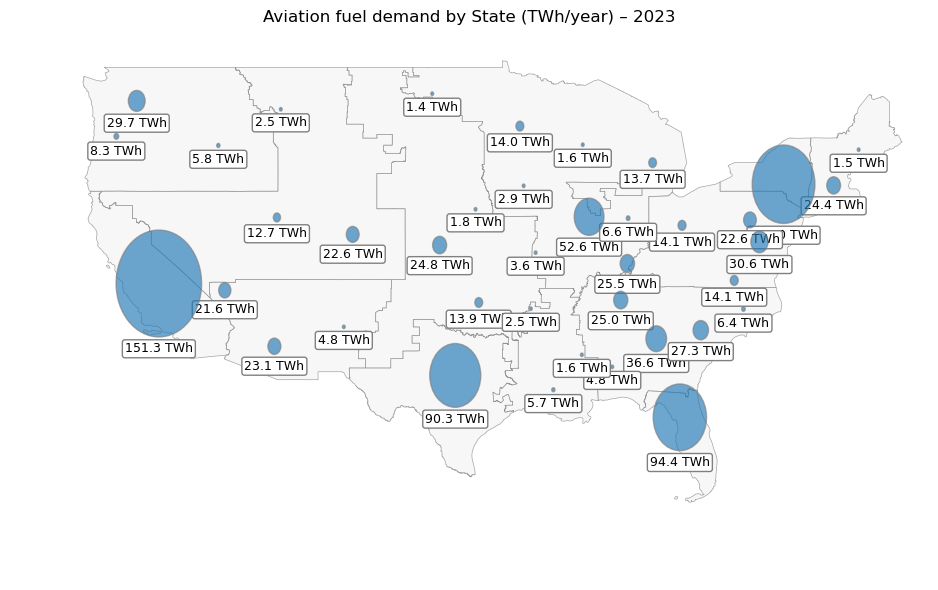


Year: 2030



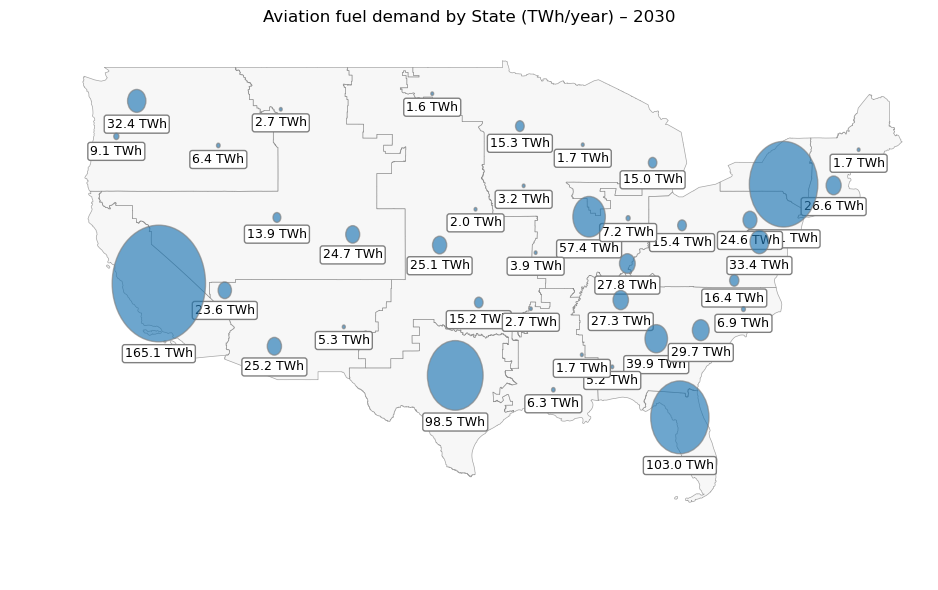

In [59]:
for network_name, n in networks.items():    
    print(f"\nYear: {network_name[-4:]}\n")
    create_aviation_demand_by_state_map(
        n,
        grid_region_shapes_path,
        network_name=network_name,
        min_demand_twh=1.0,
        year_title=True
    )
    plt.show()

In [60]:
for network_name, n in networks.items():
    print(f"\nYear: {network_name[-4:]}\n")
    ekerosene_demand_state = compute_aviation_demand_table(n, level="grid_region")
    ekerosene_demand_state.loc[:, "n. of Passengers"] = (
        ekerosene_demand_state["Share (%)"] * total_passengers / 100)
    display(ekerosene_demand_state.set_index("Grid Region")[["Fuel demand (TWh)", "n. of Passengers", "Share (%)"]])



Year: 2023



Fuel demand (TWh)  n. of Passengers  Share (%)
Grid Region                                                 
Mid-Atlantic         154.240674      1.273976e+08  15.368004
California           150.488563      1.242985e+08  14.994157
New York             110.988560      9.167279e+07  11.058514
Southeast            102.647631      8.478346e+07  10.227453
Florida               91.751227      7.578340e+07   9.141773
Texas                 89.396171      7.383821e+07   8.907123
Southwest             49.407369      4.080881e+07   4.922778
Plains                47.064631      3.887379e+07   4.689356
Northwest             45.989256      3.798557e+07   4.582209
Midwest               45.293716      3.741107e+07   4.512908
Mountain              37.133953      3.067139e+07   3.699898
New England           25.923041      2.141155e+07   2.582882
Hawaii                24.984185      2.063609e+07   2.489337
Alaska                19.895750      1.643321e+07   1.982343
Delta                  8.443334      6.973908e+06   0.841264


Year: 2030



Fuel demand (TWh)  n. of Passengers  Share (%)
Grid Region                                                 
Mid-Atlantic         169.268078      1.281294e+08  15.456291
California           164.207058      1.242985e+08  14.994157
New York             121.106245      9.167279e+07  11.058514
Southeast            112.004960      8.478346e+07  10.227453
Florida              100.115243      7.578340e+07   9.141773
Texas                 97.545501      7.383821e+07   8.907123
Southwest             53.911331      4.080881e+07   4.922778
Northwest             50.181624      3.798557e+07   4.582209
Midwest               49.422678      3.741107e+07   4.512908
Plains                49.332124      3.734253e+07   4.504640
Mountain              40.519074      3.067139e+07   3.699898
New England           28.286178      2.141155e+07   2.582882
Hawaii                27.261736      2.063609e+07   2.489337
Alaska                22.765478      1.723259e+07   2.078773
Delta                  9.213026      6.973908e+06   0.841264


Year: 2023



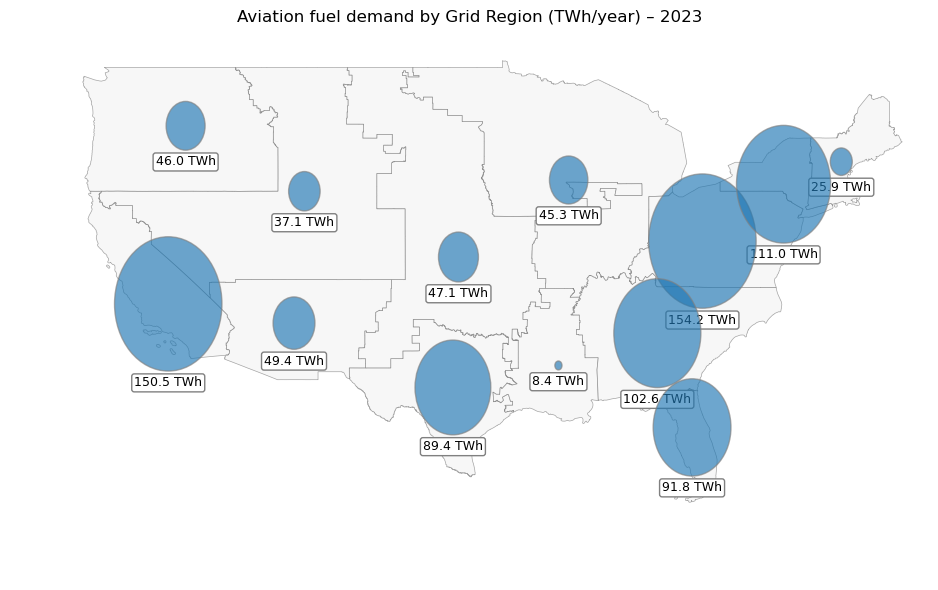


Year: 2030



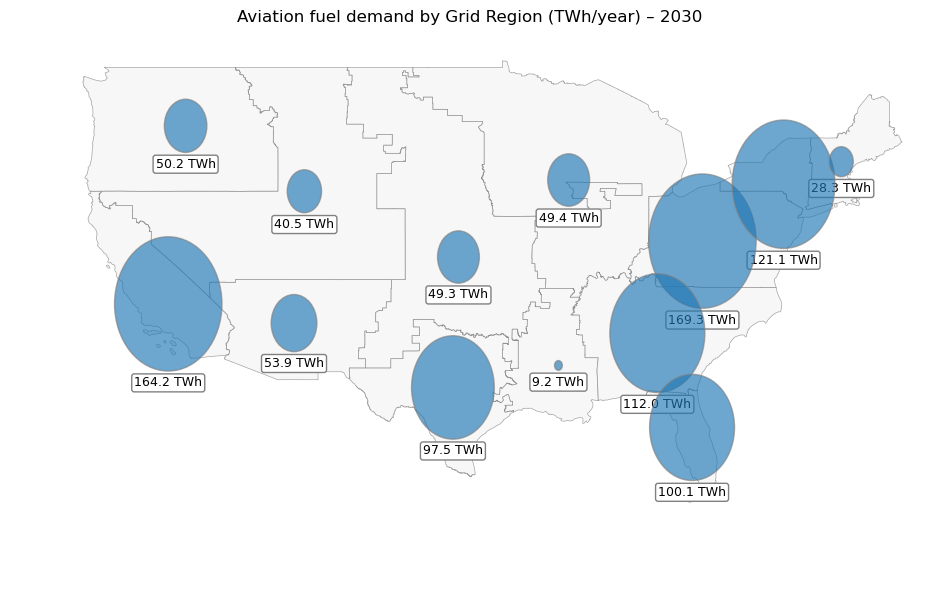

In [61]:
for network_name, n in networks.items():    
    print(f"\nYear: {network_name[-4:]}\n")
    create_aviation_demand_by_grid_region_map(
        n,
        grid_region_shapes_path,
        network_name=network_name,
        min_demand_twh=1.0,
        year_title=True
    )
    plt.show()

In [62]:
## 7.2. Required inputs for e-kerosene production

In [63]:
# Run calculation
ft_df = calculate_total_inputs_outputs_ft(networks)

print("\nElectricity / hydrogen / CO2 balance for e-kerosene production \n")

# Display without index
display(ft_df.style.hide(axis="index").format(precision=2))



Electricity / hydrogen / CO2 balance for e-kerosene production 



## 7.2. Capacity factor of e-kerosene production plants

In [64]:
# Capacity factor FT plants
cf = compute_ft_capacity_factor(networks)

print("\nFT plants capacity factor")
for year, df in cf.items():
    print(f"\nYear: {year}\n")

    # format all numeric columns to 2 decimals
    numeric_cols = df.select_dtypes(include="number").columns
    fmt = {col: "{:.2f}" for col in numeric_cols}

    display(df.style.format(fmt).hide(axis="index"))


FT plants capacity factor

Year: 2030



---

## 7.3. Economic analysis

### 7.3.1. Levelized cost of CO2 (LCOC)

In [65]:
print("LCOC cmputed using marginal price as electricity price")

lcoc_by_region = compute_LCOC_by_region(
    networks=networks,
    regional_fees=regional_fees,
    emm_mapping=emm_mapping,
    electricity_price="marginal",
    year_title=True,
    captured_threshold_mt=1e-3
)

LCOC cmputed using marginal price as electricity price
Note: LCOC is computed per ton of CO2 captured.

Year: 2030
Total captured CO2: 1.97 Mt
Weighted average LCOC (incl. T&D fees): 123.65 USD/tCO2



In [66]:
# LCOE per grid region
lcoe_gdf, table, lcoe_by_bus, lcoe_data, vmin, vmax = calculate_lcoe_summary_and_map(
    n, regions_onshore 
)
lcoe_by_region = (
    lcoe_by_bus.merge(lcoe_data[['bus', 'energy']], on='bus', how='left')
    .groupby('grid_region')
    .apply(lambda df: (df['weighted_lcoe'] * df['energy']).sum() / df['energy'].sum())
)

# LCOH per grid region (USD/kg H2)
lcoh_by_region = calculate_lcoh_by_region(
    networks,
    h2_carriers,
    regional_fees,
    emm_mapping,
    electricity_price="marginal"
)

In [67]:
print("LCOC computed using LCOE as electricity price")

lcoc_by_region = compute_LCOC_by_region(
    networks=networks,
    regional_fees=regional_fees,
    emm_mapping=emm_mapping,
    electricity_price="lcoe",
    lcoe_by_region=lcoe_by_region,
    year_title=True,
    captured_threshold_mt=1e-3
)

LCOC computed using LCOE as electricity price
Note: LCOC is computed per ton of CO2 captured.

Year: 2030
Total captured CO2: 1.97 Mt
Weighted average LCOC (incl. T&D fees): 125.12 USD/tCO2



### 7.3.2. Levelized cost of e-kerosene

In [68]:
# LCO e-kerosene using marginal prices

print("LCO e-kerosene computed using marginal prices for electricity, hydrogen, and CO2")

LCO_ekerosene_by_region = compute_LCO_ekerosene_by_region(
    networks=networks,
    fx_2020=1.14,      
    fx_recent=1.08,    
    regional_fees=regional_fees,
    emm_mapping=emm_mapping,
    unit="gal",        
    year_title=True,
    p_nom_threshold=1e-3,
    electricity_price="marginal",
    hydrogen_price="marginal",
    co2_price="marginal"
)

LCO e-kerosene computed using marginal prices for electricity, hydrogen, and CO2

2030:
Weighted average LCO e-kerosene (incl. T&D): 5.22 USD/gal e-ker
Total production: 7.67 TWh



In [69]:
lcoc_by_region = calculate_LCOC_by_region(
    networks=networks,
    regional_fees=regional_fees,
    emm_mapping=emm_mapping,
    electricity_price="marginal",
    captured_threshold_mt=1e-3
)

In [70]:
print("LCO e-kerosene computed using LCOE, LCOH and LCOC as input prices")

LCO_ekerosene_by_region = compute_LCO_ekerosene_by_region(
    networks=networks,
    fx_2020=1.14,
    fx_recent=1.08,
    regional_fees=regional_fees,
    emm_mapping=emm_mapping,
    unit="gal",           
    year_title=True,
    p_nom_threshold=1e-3,
    electricity_price="lcoe",
    hydrogen_price="lcoh",
    co2_price="lcoc",
    lcoe_by_region=lcoe_by_region,
    lcoh_by_region=lcoh_by_region,
    lcoc_by_region=lcoc_by_region
)

LCO e-kerosene computed using LCOE, LCOH and LCOC as input prices

2030:
Weighted average LCO e-kerosene (incl. T&D): 9.77 USD/gal e-ker
Total production: 7.67 TWh



#### Definition: Levelized Cost of e-Kerosene

The levelized cost of e-kerosene is calculated as:

$$
\text{LCO}_{\text{e-kerosene}} \,[\$/\text{gal}] =
\frac{\sum_t \big(P^{\text{elec}}_t \cdot E^{\text{in}}_t\big)}{\sum_t E^{\text{out}}_t}
+ \frac{\sum_t \big(P^{\text{H2}}_t \cdot H^{\text{in}}_t\big)}{\sum_t E^{\text{out}}_t}
+ \frac{\sum_t \big(P^{\text{CO2}}_t \cdot C^{\text{in}}_t\big)}{\sum_t E^{\text{out}}_t}
+ \frac{CAPEX \cdot P_{\text{nom}}}{\sum_t E^{\text{out}}_t}
+ VOM
$$

---

## Definitions

- $P^{\text{elec}}_t$ = electricity price at time *t* (USD/MWh)
- $E^{\text{in}}_t$ = electricity input at time *t* (MWh)

- $P^{\text{H2}}_t$ = hydrogen price at time *t* (USD/MWh)
- $H^{\text{in}}_t$ = hydrogen input at time *t* (MWh)

- $P^{\text{CO2}}_t$ = CO2 price at time *t* (USD/t CO2)
- $C^{\text{in}}_t$ = CO2 input at time *t* (t CO2)

- $E^{\text{out}}_t$ = e-kerosene output at time *t* (MWh)

- $CAPEX$ = annualized capital cost (USD/MW a)
- $P_{\text{nom}}$ = installed Fischer–Tropsch plant capacity (MW)

- $VOM$ = variable O&M cost (USD/MWh)

- $\eta_{\text{gal}}$ = conversion factor from MWh to gallons  

$$
\eta_{\text{gal}} =
\frac{34 \,\text{MJ/l} \times 3.78541 \,\text{L/gal}}{3600 \,\text{MJ/MWh}}
\;\approx\; 0.0357 \,\text{MWh/gal}
$$


---

## 8. Industrial sector analysis

## 8.1 Industrial production
This section focuses on the production from the different industrial sectors related to e-kerosene production (point-source CO2).

In [71]:
carriers_of_interest = ['NH3', 'ethanol', 'DRI', 'steel BF-BOF', 'steel EAF', 'cement']

In [72]:
# Specific conversion per carrier
conversion_factors = {
    "cement": (1 / 1000, "kt/year"),
    "DRI": (1 / 1000, "kt/year"),
    "steel BF-BOF": (1 / 1000, "kt/year"),
    "steel EAF": (1 / 1000, "kt/year"),
    "ethanol": (1/ 80.2 * 3600 / 1e6, "MMgallon/year"),
    "NH3": (1/ 5.17 / 1e3, "thousand metric tons/year"), 
}

summary_all = {}
units = {}

for name, network in networks.items(): 

    filtered_loads = network.loads[network.loads["carrier"].isin(carriers_of_interest)].copy()

    filtered_loads["state"] = filtered_loads["bus"].map(network.buses["state"])

    summary = (
        filtered_loads.groupby("carrier")["p_set"]
        .sum()
        .mul(8760)  # convert from MW to MWh/year
        .reindex(carriers_of_interest)
        .fillna(0)
    )

    converted = []
    unit_column = []
    for carrier in carriers_of_interest:
        value = summary.get(carrier, 0)
        factor, unit = conversion_factors.get(carrier, (1, "MWh/year"))
        converted.append(round(value * factor, 2))
        unit_column.append(unit)

    summary_converted = pd.Series(converted, index=carriers_of_interest)
    year = name[-4:]  # Extract year from network name
    summary_all[year] = summary_converted

    if "Unit" not in units:
        units["Unit"] = unit_column 

summary_df = pd.DataFrame(summary_all)
summary_df["Unit"] = units["Unit"]

pd.set_option('display.float_format', '{:,.2f}'.format)

print("\nTotal production by industrial product\n")
display(summary_df)


Total production by industrial product



2023       2030                       Unit
NH3           17,215.00  19,371.07  thousand metric tons/year
ethanol       18,010.70  18,010.70              MMgallon/year
DRI            6,400.00   6,627.39                    kt/year
steel BF-BOF  36,854.00  38,163.40                    kt/year
steel EAF     78,072.39  80,846.25                    kt/year
cement       141,374.68 149,484.22                    kt/year

In [73]:
def plot_geostorage_daily(networks):
    for key, n in networks.items():
        geo_stores = n.stores.index[n.stores.carrier == "co2 stored"]
        if geo_stores.empty:
            print(f"No permanent CO2 storage in {key}")
            continue

        # serie snapshot
        flows = n.stores_t.p[geo_stores].sum(axis=1) / 1e6   # MtCO2 / snapshot
        stock = n.stores_t.e[geo_stores].sum(axis=1) / 1e6   # MtCO2

        # resample giornaliero (media)
        flows_daily = flows.resample("1D").mean()
        stock_daily = stock.resample("1D").mean()

        year = key[-4:]

        fig, axes = plt.subplots(2, 1, figsize=(15,8), sharex=True)

        flows_daily.plot(ax=axes[0], color="tab:blue", lw=1.2)
        axes[0].axhline(0, color="k", lw=0.8)
        axes[0].set_ylabel("CO2 flow (Mt)")
        axes[0].set_title(f"CO2 permanent storage – {year}")

        stock_daily.plot(ax=axes[1], color="tab:green", lw=1.5)
        axes[1].set_ylabel("Stock CO2 (Mt)")
        axes[1].set_xlabel("Time")

        start = flows_daily.index.min().replace(day=1)
        end = flows_daily.index.max()
        month_starts = pd.date_range(start=start, end=end, freq="MS")
        axes[1].set_xlim(start, end)
        axes[1].set_xticks(month_starts)
        axes[1].set_xticklabels(month_starts.strftime("%b"))

        for ax in axes:
            ax.grid(True)

        plt.tight_layout()
        plt.show()

plot_geostorage_daily(networks)

No permanent CO2 storage in Base_2023
No permanent CO2 storage in scenario_02_2030


## 8.2 Industrial emissions
This section focuses on the analysis of the CO2 commodity, with particular reference to the industrial sector and the use for e-kerosene production.

In [74]:
for key, net in networks.items():
    year = key[-4:]
    print(f"\nYear: {year}\n")

    df = compute_emissions_from_links(net)

    df_nonzero = df[
        (df["CO2 to Atmosphere (Mt CO2/year)"] != 0) |
        (df["CO2 Captured (Mt CO2/year)"] != 0) |
        (df["CO2 Sequestered (Mt CO2/year)"] != 0) |
        (df["Net CO2 Emissions (Mt CO2/year)"] != 0)
    ]

    display(df_nonzero.style.format(precision=2).hide(axis="index"))



Year: 2023




Year: 2030



In [75]:
carrier_groups = {
    "BF-BOF": ["BF-BOF", "BF-BOF CC"],
    "DRI": ["DRI", "DRI CC"],
    "ethanol": ["ethanol from starch", "ethanol from starch CC"],
    "SMR": ["SMR", "SMR CC"],
    "dry clinker": ["dry clinker", "dry clinker CC"],
    "DAC": ["DAC"]
}

In [76]:
for key, net in networks.items():
    
    year = key[-4:]
    print(f"\nYear: {year}\n")

    # emissions summary
    df_summary = compute_emissions_grouped(net, carrier_groups)

    # Keep non-zero rows only
    df_filtered = df_summary[
        (df_summary[
            [
                "CO2 to Atmosphere (Mt CO2/year)",
                "CO2 Captured (Mt CO2/year)",
                "CO2 Sequestered (Mt CO2/year)",
                "Net CO2 Emissions (Mt CO2/year)"
            ]
        ].abs().sum(axis=1) > 0)
    ].copy()

    for col in [
        "CO2 to Atmosphere (Mt CO2/year)",
        "CO2 Captured (Mt CO2/year)",
        "CO2 Sequestered (Mt CO2/year)",
        "Net CO2 Emissions (Mt CO2/year)"
    ]:
        df_filtered[col] = df_filtered[col].apply(lambda x: 0.0 if abs(x) < 1e-6 else x)

    # Biogenic-only scenarios
    biogenic_only = any(s in key for s in [
        "scenario_05", "scenario_06", "scenario_10"
    ])
    if biogenic_only:
        total_stored = df_filtered.loc[
            df_filtered["carrier_group"] == "ethanol", "CO2 Sequestered (Mt CO2/year)"
        ].sum()
        note = " (biogenic CO2 only)"
    else:
        total_stored = df_filtered["CO2 Sequestered (Mt CO2/year)"].sum()
        note = ""

    # Geological storage accounting
    co2_stores = net.stores.index[net.stores.carrier == "co2 stored"]

    if len(co2_stores):
        w = net.snapshot_weightings["stores"]

        inflow_Mt = (
            (-net.stores_t.p[co2_stores].clip(upper=0))
            .mul(w, axis=0).sum().sum() / 1e6
        )
        start_stock_Mt = net.stores.loc[co2_stores, "e_initial"].fillna(0).sum() / 1e6
        end_stock_Mt   = net.stores_t.e.loc[net.snapshots[-1], co2_stores].sum() / 1e6
    else:
        inflow_Mt = start_stock_Mt = end_stock_Mt = 0.0

    # Print summary
    print(f"Total CO2 sequestered{note} (annual flows): {total_stored:.2f} Mt CO2")
    print(f"Total CO2 injected into geological storage - annual inflow: {inflow_Mt:.2f} Mt CO2")
    print(f"Start stock: {start_stock_Mt:.2f} Mt CO2")
    print(f"End stock: {end_stock_Mt:.2f} Mt CO2\n")

    # Show table only if not empty
    if not df_filtered.empty:
        display(df_filtered.style.format(precision=2).hide(axis='index'))
    else:
        print("")



Year: 2023

Total CO2 sequestered (annual flows): 0.00 Mt CO2
Total CO2 injected into geological storage - annual inflow: 0.00 Mt CO2
Start stock: 0.00 Mt CO2
End stock: 0.00 Mt CO2




Year: 2030

Total CO2 sequestered (annual flows): 0.00 Mt CO2
Total CO2 injected into geological storage - annual inflow: 0.00 Mt CO2
Start stock: 0.00 Mt CO2
End stock: 0.00 Mt CO2



In [ ]:
all_dfs = []
global_max = 0.0

for name, net in networks.items():
    year = re.search(r"\d{4}", str(name)).group()
    df_state = compute_emissions_by_state(net, carrier_groups)
    if df_state.empty:
        continue

    df_state["year"] = year
    all_dfs.append(df_state)

    mx = df_state["Net CO2 Emissions (Mt CO2/year)"].abs().max()
    if mx > global_max:
        global_max = mx

for df in all_dfs:
    year = df["year"].iloc[0]
    plot_emissions_maps_by_group(
        all_state_emissions=df,
        path_shapes=state_shapes_path,
        title=year,
        column="Net CO2 Emissions (Mt CO2/year)",
        vmin=-global_max,
        vmax= global_max
    )
